# 深度强化学习－用卷积神经网络实现AI玩Flappy Bird游戏

本节课我们结合Flappy bird游戏，详细讲述了深度强化学习原理，以及如何训练一个神经网络来玩儿游戏

整个代码包括了利用PyGame包实现一个Flappy Bird游戏，卷积神经网络的定义与实现，以及深度强化学习算法。

本程序参考了AI玩Flappy Bird的TensorFlow版本：https://github.com/yenchenlin/DeepLearningFlappyBird

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第X课的配套源代码

## 一、PyGAME实现Flappy Bird游戏

在这部分中，我们调用PyGame包实现了一个Flappy Bird游戏。通过PyGame，我们可以非常方便的加载图片、音频，来快速实现小游戏

### 1. 加载游戏所需的必要资源

### 2. 实现Flappy Bird的游戏逻辑

In [5]:
# 加载游戏中的所有资源，包括图片以及音频
# 调用PyGame包，关于该包的安装，请参看：http://www.pygame.org/wiki/GettingStarted
import pygame

# 需要获取操作系统类型，故而调用sys包
import sys
# 加载程序所需的包
import numpy as np
import sys
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

FPS = 40 #帧率
SCREENWIDTH  = 400 #屏幕的宽度
SCREENHEIGHT = 300 #屏幕的高度

pygame.init() #游戏初始化
pygame.display.list_modes()
FPSCLOCK = pygame.time.Clock() #定义程序时钟
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT)) #定义屏幕对象
screen = SCREEN
pygame.display.set_caption('PlaneSurvival') #设定窗口名称


ENEMY_FREQ = 800

# Define our player object and call super to give it all the properties and methods of pygame.sprite.Sprite
# The surface we draw on the screen is now a property of 'player'
class GameState(pygame.sprite.Sprite):
    def __init__(self):
        super(GameState, self).__init__()
        self.surf = pygame.Surface((80, 30))
        self.surf.fill((255, 255, 255))
        self.rect = self.surf.get_rect()
        self.rect.move_ip(0, 100)
        
        self.enemies = []
        
        self.background = pygame.Surface(screen.get_size())
        self.background.fill((0, 0, 0))
        
        self.reward = 0.1
        

    def frame_step(self, input_actions):
        # input_actions是一个行动数组，分别存储了3个动作的激活情况
        # input_actions[0] == 1: 对应什么都不做
        # input_actions[1] == 1: 对应UP
        # input_actions[2] == 1: 对应DOWN
        
        pygame.event.pump()
        
        # 每一步的默认回报
        self.reward = 0.1
        terminal = False
        
        # 限定每一帧只能做一个动作
        if sum(input_actions) != 1:
            raise ValueError('Multiple input actions!')
            
            
        if input_actions[1]:
            self.rect.move_ip(0, -5)
        if input_actions[2]:
            self.rect.move_ip(0, 5)
        # if pressed_keys[K_LEFT]:
        #    self.rect.move_ip(-5, 0)
        # if pressed_keys[K_RIGHT]:
        #    self.rect.move_ip(5, 0)
            
        # Keep player on the screen
        if self.rect.left < 0:
            self.rect.left = 0
        elif self.rect.right > SCREENWIDTH:
            self.rect.right = SCREENWIDTH
        if self.rect.top <= 0:
            self.rect.top = 0
        elif self.rect.bottom >= SCREENHEIGHT:
            self.rect.bottom = SCREENHEIGHT
            
        ### Add enemies    
        #for event in pygame.event.get():
            #if event.type == KEYDOWN:
            #    if event.key == K_ESCAPE:
            #        terminal = True
            #elif event.type == QUIT:
            #    terminal = True
        if(random.random() < 0.025):
            new_enemy = Enemy(self)
            self.enemies.append(new_enemy)
        ####
        
        for e in self.enemies:
            e.update()
            
        self.enemies = [e for e in self.enemies if e.dead == False ]
        #print(len(self.enemies))
        
        if pygame.sprite.spritecollideany(self, self.enemies):
            terminal = True
            self.__init__()
            self.reward = -1
        
        # Draw everything on screen
        screen.blit(self.background, (0, 0))
        # screen.blit(self.surf, self.rect)
        for entity in self.enemies:
            screen.blit(entity.surf, entity.rect)
        screen.blit(self.surf, self.rect)
        
        
        # 将当前的游戏屏幕生成一个二维画面返回
        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        FPSCLOCK.tick(FPS)
        #print(self.reward)
        return image_data, self.reward, terminal

class Enemy(pygame.sprite.Sprite):
    def __init__(self, state):
        super(Enemy, self).__init__()
        self.surf = pygame.Surface((80, 20))
        self.surf.fill((255,255,255))
        self.rect = self.surf.get_rect(
            center=(random.randint(400, 500), random.randint(0, 300))
        )
        self.speed = random.randint(2, 6)
        
        self.state = state
        self.dead = False

    def update(self):
        self.rect.move_ip(-self.speed, 0)
        if self.rect.right < 0:
            self.state.reward = self.state.reward + 1
            self.kill()
            self.dead = True


### 3. 对游戏做小测试

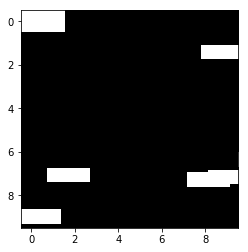

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 新建一个游戏
game = GameState()


fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)


# 进行100步循环，并将每一帧的画面打印出来
for i in range(200):
    clear_output(wait = True)
    
    image_data, reward, terminal = game.frame_step([0,1,0])
    
    image = np.transpose(image_data, (1, 0, 2))
    img.set_data(image)
    img.autoscale()
    display(fig)


## 二、训练神经网络玩游戏

### 1. 定义网络

In [13]:
#  导入必需的包
from __future__ import print_function

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2 #需要安装OpenCV的包
import sys
sys.path.append("game/")
import random
import numpy as np
from collections import deque


# 定义一系列常数，其中，epsilon为每周期随机输出一个动作的概率
GAME = 'bird' # 游戏名称
ACTIONS = 3 # 有效输出动作的个数
GAMMA = 0.99 # 强化学习中未来的衰减率
OBSERVE = 5000. # 训练之前的时间步，需要先观察10000帧
EXPLORE = 3000000. # 退火所需的时间步，所谓的退火就是指随机选择率epsilon逐渐变小
FINAL_EPSILON = 0.0001 # epsilon的最终值
INITIAL_EPSILON = 0.2 # epsilon的初始值
REPLAY_MEMORY = 30000 # 最多记忆多少帧训练数据 # 50000
BATCH = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出

In [8]:

# 创建一个多层CNN网络，该网络接收的输入为4帧画面，输出为每个可能动作对应的Q函数值
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一层卷积，从4通道到32通道，窗口大小8，跳跃间隔4，填空白2
        self.conv1 = nn.Conv2d(4, 32, 8, 4, padding = 2)
        # Pooling层，窗口2*2
        self.pool = nn.MaxPool2d(2, 2)
        # 第二层卷积，从32通道到64通道，窗口大小4，跳跃间隔2，填空白1
        self.conv2 = nn.Conv2d(32, 64, 4, 2, padding = 1)
        # 第二个Pooling层，窗口2＊2，空白1
        self.pool2 = nn.MaxPool2d(2, 2, padding = 1)
        # 第三层卷积层，输入输出通道都是64，填空白为1
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding = 1)
        
        # 最后有两层全链接层
        self.fc_sz = 1600
        self.fc1 = nn.Linear(self.fc_sz, 256)
        self.fc2 = nn.Linear(256, ACTIONS)

    def forward(self, x):
        # 输入为一个batch的数据，每一个为前后相连的4张图像，每个图像为80*80的大小
        # x的尺寸为：batch_size, 4, 80, 80
        x = self.conv1(x)
        # x的尺寸为：batch_size, 32, 20, 20
        x = F.relu(x)
        x = self.pool(x)
        # x的尺寸为：batch_size, 32, 10, 10
        x = F.relu(self.conv2(x))
        # x的尺寸为：batch_size, 64, 5, 5
        #x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # x的尺寸为：batch_size, 64, 5, 5
        #x = self.pool2(x)
        # 将x设为1600维的向量, batch_size, 1600
        x = x.view(-1, self.fc_sz)
        x = F.relu(self.fc1(x))
        readout = self.fc2(x)
        return readout, x
    def init(self):
        # 初始化所有的网络权重
        self.conv1.weight.data =  torch.abs(0.01 * torch.randn(self.conv1.weight.size()))
        self.conv2.weight.data =  torch.abs(0.01 * torch.randn(self.conv2.weight.size()))
        self.conv3.weight.data =  torch.abs(0.01 * torch.randn(self.conv3.weight.size()))
        self.fc1.weight.data = torch.abs(0.01 * torch.randn(self.fc1.weight.size()))
        self.fc2.weight.data = torch.abs(0.01 * torch.randn(self.fc2.weight.size()))
        self.conv1.bias.data = torch.ones(self.conv1.bias.size()) * 0.01
        self.conv2.bias.data = torch.ones(self.conv2.bias.size()) * 0.01
        self.conv3.bias.data = torch.ones(self.conv3.bias.size()) * 0.01
        self.fc1.bias.data = torch.ones(self.fc1.bias.size()) * 0.01
        self.fc2.bias.data = torch.ones(self.fc2.bias.size()) * 0.01

In [9]:
# 开始在内存／GPU上定义一个网络
use_cuda = torch.cuda.is_available() #检测本台机器中是否有GPU
print('use_cuda', use_cuda)
# 创建一个神经网络
net = Net()
# 初始化网络权重。之所以自定义初始化过程是为了增加神经网络权重的多样性
net.init()
# 如果有GPU，就把神经网络全部搬到GPU内存中做运算
net = net.cuda() if use_cuda else net

# 定义损失函数为MSE
criterion = nn.MSELoss().cuda() if use_cuda else nn.MSELoss()
# 定义优化器，并设置初始学习率维10^-6
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6 )

# 开启一个游戏进程，开始与游戏引擎通话
game_state = GameState()


# 学习样本的存储区域deque是一个类似于list的存储容器
D = deque()

# 状态打印log记录位置
#a_file = open("logs_" + GAME + "/readout.txt", 'w')
#h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# 将游戏设置为初始状态，并获得一个80*80的游戏湖面
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)

# 将初始的游戏画面叠加成4张作为神经网络的初始输入状态s_t
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)



use_cuda True


### 2. 边做边学的核心算法

该算法分为三个阶段：

1、按照Epsilon贪婪算法采取一次行动；
2、将选择好的行动输入给游戏引擎，得到下一帧的状态，并生成本帧的训练数据
3、开始训练：

In [14]:
# 设置初始的epsilon（采取随机行动的概率），并准备训练
epsilon = INITIAL_EPSILON
t = 0

# 记录每轮平均得分的容器
scores = []
all_turn_scores = []
while "plane survival" != "angry bird":
    # 开始游戏循环
    ######################################################
    ##########首先，按照贪婪策略选择一个行动 ##################
    s = Variable(torch.from_numpy(s_t).type(torch.FloatTensor))
    s = s.cuda() if use_cuda else s
    s = s.view(-1, s.size()[0], s.size()[1], s.size()[2])
    # 获取当前时刻的游戏画面，输入到神经网络中
    readout, h_fc1 = net(s)
    # 神经网络产生的输出为readout：选择每一个行动的预期Q值
    readout = readout.cpu() if use_cuda else readout
    # readout为一个二维向量，分别对应每一个动作的预期Q值
    readout_t = readout.data.numpy()[0]

    # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
    # 1-epsilon的概率按照预期输出最大的Q值给出行动
    a_t = np.zeros([ACTIONS])
    action_index = 0
    action_index_old = action_index
    if t % FRAME_PER_ACTION == 0:
        # 如果当前帧可以行动，则
        if random.random() <= epsilon:
            # 产生随机行动
            #print("----------Random Action----------")
            if random.random() < 0.6:
                action_index = action_index_old
            else:
                action_index = random.randrange(ACTIONS)
                action_index_old = action_index
        else:
            # 选择神经网络判断的预期Q最大的行动
            action_index = np.argmax(readout_t)
            action_index_old = action_index
            
        a_t[action_index] = 1
    else:
        a_t[0] = 1 # do nothing

    # 模拟退火：让epsilon开始降低
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

    ######################################################################### 
    ##########其次，将选择好的行动输入给游戏引擎，并得到下一帧的状态 ################### 
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    # 返回的x_t1_colored为游戏画面，r_t为本轮的得分，terminal为游戏在本轮是否已经结束
    
    # 记录一下每一步的成绩
    scores.append(r_t)
    if terminal:
        # 当游戏结束的时候，计算一下本轮的总成绩，并将总成绩存储到all_turn_scores中
        all_turn_scores.append(sum(scores))
        scores = []
    
    # 对游戏的原始画面做相应的处理，从而变成一张80*80的，朴素的（无背景画面）的图
    x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
    x_t1 = np.reshape(x_t1, (1, 80, 80))
    # 将当前帧的画面和前三帧的画面合并起来作为Agent获得的环境反馈结果
    s_t1 = np.append(x_t1, s_t[:3, :, :], axis=0)
    # 生成一个训练数据，分别将本帧的输入画面s_t,本帧的行动a_t，得到的环境回报r_t以及环境被转换的新状态s_t1存到D中
    D.append((s_t, a_t, r_t, s_t1, terminal))
    if len(D) > REPLAY_MEMORY:
        # 如果D中的元素已满，则扔掉最老的一条训练数据
        D.popleft()

    ######################################################################### 
    ##########最后，当运行周期超过一定次数后开始训练神经网络 ################### 
    if t > OBSERVE:
        # 从D中随机采样出一个batch的训练数据
        minibatch = random.sample(D, BATCH)
        optimizer.zero_grad()

        # 将这个batch中的s变量都分别存放到列表中
        s_j_batch = [d[0] for d in minibatch]
        a_batch = [d[1] for d in minibatch]
        r_batch = [d[2] for d in minibatch]
        s_j1_batch = [d[3] for d in minibatch]

        # 接下来，要根据s_j1_batch，神经网络给出预估的未来Q值
        
        s = Variable(torch.FloatTensor(np.array(s_j1_batch, dtype=float)))
        s = s.cuda() if use_cuda else s
        readout, h_fc1 = net(s)
        readout = readout.cpu() if use_cuda else readout
        readout_j1_batch = readout.data.numpy()
        # readout_j1_batch存储了一个minibatch中的所有未来一步的Q预估值
        # 根据Q的预估值，当前的反馈r，以及游戏是否结束，更新待训练的目标函数值
        y_batch = []
        for i in range(0, len(minibatch)):
            terminal = minibatch[i][4]
            # 当游戏结束的时候，则用环境的反馈作为目标，否则用下一状态的Q值＋本期的环境反馈
            if terminal:
                y_batch.append(r_batch[i])
            else:
                y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

        # 开始梯度更新
        y = Variable(torch.FloatTensor(y_batch))
        a = Variable(torch.FloatTensor(a_batch))
        s = Variable(torch.FloatTensor(np.array(s_j_batch, dtype=float)))
        if use_cuda:
            y = y.cuda()
            a = a.cuda()
            s = s.cuda()
        # 计算s_j_batch的Q值
        readout, h_fc1 = net(s)
        readout_action = readout.mul(a).sum(1)
        # 根据s_j_batch下所选择的预估Q和目标y的Q值的差来作为损失函数训练网络
        loss = criterion(readout_action, y)
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            print('损失函数：', loss.cpu().data.numpy()[0])
       

    # 将状态更新一次，时间步＋1
    s_t = s_t1
    t += 1

    # 每隔 10000 次循环，存储一下网络
    if t % 10000 == 0:
        torch.save(net, 'saving_nets/' + GAME + '-dqn' + str(t) + '.txt')
    
    # 状态信息的转化，基本分为Observe，explore和train三个阶段
    # Observe没有训练，explore开始训练，并且开始模拟退火，train模拟退火结束
    state = ""
    if t <= OBSERVE:
        state = "observe"
    elif t > OBSERVE and t <= OBSERVE + EXPLORE:
        state = "explore"
    else:
        state = "train"
        
    # 打印当前运行的一些基本数据，分别输出到屏幕以及log文件中
    if t % 1000 == 0:
        sss = "时间步 {}/ 状态 {}/ Epsilon {:.2f}/ 行动 {}/ 奖励 {}/ Q_MAX {:e}/ 轮得分 {:.2f}".format(
            t, state, epsilon, action_index, r_t, np.max(readout_t), np.mean(all_turn_scores[-1000:]))
        print(sss)
        f = open('log_file.txt', 'a')
        f.write(sss + '\n')
        f.close()
    # write info to files


时间步 1000/ 状态 observe/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 9.948210e+00/ 轮得分 51.95
时间步 2000/ 状态 observe/ Epsilon 0.20/ 行动 2/ 奖励 0.1/ Q_MAX 9.666224e+00/ 轮得分 44.90
时间步 3000/ 状态 observe/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.112597e+01/ 轮得分 44.87
时间步 4000/ 状态 observe/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 7.258551e+00/ 轮得分 44.87
时间步 5000/ 状态 observe/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.307988e+01/ 轮得分 58.61
时间步 6000/ 状态 explore/ Epsilon 0.20/ 行动 2/ 奖励 0.1/ Q_MAX 1.102176e+01/ 轮得分 58.61
损失函数： 0.0514011
时间步 7000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 7.753469e+00/ 轮得分 60.57
损失函数： 0.0514402
时间步 8000/ 状态 explore/ Epsilon 0.20/ 行动 1/ 奖励 0.1/ Q_MAX 9.923781e+00/ 轮得分 46.65
损失函数： 0.104612
时间步 9000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.058077e+01/ 轮得分 42.68
损失函数： 0.163438


/home/fuyang/Workspace/deep_learning_tutorial/p3ml-venv/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


时间步 10000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.321112e+01/ 轮得分 40.32
损失函数： 0.0907798
时间步 11000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 8.017292e+00/ 轮得分 42.76
损失函数： 0.0516603
时间步 12000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.270808e+01/ 轮得分 40.65
损失函数： 0.0749432
时间步 13000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.171060e+01/ 轮得分 42.13
损失函数： 0.120877
时间步 14000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 8.742262e+00/ 轮得分 43.21
损失函数： 0.103294
时间步 15000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.115907e+01/ 轮得分 43.40
损失函数： 0.0498901
时间步 16000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.204202e+01/ 轮得分 43.62
损失函数： 0.105298
时间步 17000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.186220e+01/ 轮得分 44.58
损失函数： 0.0976257
时间步 18000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 1.056993e+01/ 轮得分 45.66
损失函数： 0.135102
时间步 19000/ 状态 explore/ Epsilon 0.20/ 行动 0/ 奖励 0.1/ Q_MAX 7.150744e+00/ 轮得分 45.86
损失函数： 0.089778
时间步 20000/ 状态 explore/ Epsilon 0.20

时间步 95000/ 状态 explore/ Epsilon 0.19/ 行动 2/ 奖励 0.1/ Q_MAX 1.317497e+01/ 轮得分 50.70
损失函数： 0.0960017
时间步 96000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 8.976020e+00/ 轮得分 50.65
损失函数： 0.100324
时间步 97000/ 状态 explore/ Epsilon 0.19/ 行动 2/ 奖励 0.1/ Q_MAX 1.087120e+01/ 轮得分 50.49
损失函数： 0.315624
时间步 98000/ 状态 explore/ Epsilon 0.19/ 行动 1/ 奖励 0.1/ Q_MAX 1.046627e+01/ 轮得分 50.53
损失函数： 0.107109
时间步 99000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 6.860285e+00/ 轮得分 50.38
损失函数： 0.0413301
时间步 100000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 9.758416e+00/ 轮得分 50.14
损失函数： 0.045304
时间步 101000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 1.114892e+01/ 轮得分 49.80
损失函数： 0.115859
时间步 102000/ 状态 explore/ Epsilon 0.19/ 行动 2/ 奖励 0.1/ Q_MAX 9.629707e+00/ 轮得分 49.86
损失函数： 0.0358414
时间步 103000/ 状态 explore/ Epsilon 0.19/ 行动 2/ 奖励 0.1/ Q_MAX 1.155232e+01/ 轮得分 49.38
损失函数： 0.147884
时间步 104000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 9.809592e+00/ 轮得分 49.46
损失函数： 0.0653663
时间步 105000/ 状态 explore/ Epsilon

时间步 180000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 1.006668e+01/ 轮得分 49.59
损失函数： 0.0868385
时间步 181000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 1.070648e+01/ 轮得分 49.48
损失函数： 0.76483
时间步 182000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 1.1/ Q_MAX 9.950573e+00/ 轮得分 49.45
损失函数： 0.0647567
时间步 183000/ 状态 explore/ Epsilon 0.19/ 行动 2/ 奖励 0.1/ Q_MAX 7.730804e+00/ 轮得分 49.12
损失函数： 6.3157
时间步 184000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 1.137236e+01/ 轮得分 48.92
损失函数： 0.208313
时间步 185000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 1.066272e+01/ 轮得分 48.83
损失函数： 0.291029
时间步 186000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 1.021597e+01/ 轮得分 48.76
损失函数： 0.0663119
时间步 187000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX 7.228743e+00/ 轮得分 48.70
损失函数： 0.21579
时间步 188000/ 状态 explore/ Epsilon 0.19/ 行动 2/ 奖励 0.1/ Q_MAX 1.105377e+01/ 轮得分 48.86
损失函数： 0.0495094
时间步 189000/ 状态 explore/ Epsilon 0.19/ 行动 0/ 奖励 0.1/ Q_MAX -1.041290e-01/ 轮得分 48.70
损失函数： 0.126926
时间步 190000/ 状态 explore/ Epsil

时间步 265000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 8.451674e+00/ 轮得分 50.49
损失函数： 0.0606363
时间步 266000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.135862e+01/ 轮得分 50.56
损失函数： 0.073372
时间步 267000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.118546e+01/ 轮得分 50.58
损失函数： 0.0828719
时间步 268000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.290794e+01/ 轮得分 50.51
损失函数： 0.126261
时间步 269000/ 状态 explore/ Epsilon 0.18/ 行动 2/ 奖励 0.1/ Q_MAX 7.697596e+00/ 轮得分 50.47
损失函数： 0.0681697
时间步 270000/ 状态 explore/ Epsilon 0.18/ 行动 2/ 奖励 0.1/ Q_MAX 1.215415e+01/ 轮得分 50.43
损失函数： 0.0927714
时间步 271000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.099031e+01/ 轮得分 50.45
损失函数： 0.104789
时间步 272000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 4.621116e+00/ 轮得分 50.45
损失函数： 0.0572281
时间步 273000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 9.918471e+00/ 轮得分 50.71
损失函数： 0.103373
时间步 274000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.289599e+01/ 轮得分 50.59
损失函数： 0.0706506
时间步 275000/ 状态 explore/ 

时间步 350000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.180791e+01/ 轮得分 54.65
损失函数： 0.114085
时间步 351000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.265911e+01/ 轮得分 54.59
损失函数： 0.104154
时间步 352000/ 状态 explore/ Epsilon 0.18/ 行动 2/ 奖励 0.1/ Q_MAX 1.252962e+01/ 轮得分 54.65
损失函数： 0.0502789
时间步 353000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 9.159765e+00/ 轮得分 54.57
损失函数： 0.0790631
时间步 354000/ 状态 explore/ Epsilon 0.18/ 行动 2/ 奖励 0.1/ Q_MAX 1.281281e+01/ 轮得分 54.55
损失函数： 0.0470721
时间步 355000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.258810e+01/ 轮得分 54.47
损失函数： 0.168296
时间步 356000/ 状态 explore/ Epsilon 0.18/ 行动 1/ 奖励 0.1/ Q_MAX 7.658892e+00/ 轮得分 54.59
损失函数： 0.085372
时间步 357000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.273576e+01/ 轮得分 54.51
损失函数： 0.099091
时间步 358000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 8.557486e+00/ 轮得分 54.49
损失函数： 0.290855
时间步 359000/ 状态 explore/ Epsilon 0.18/ 行动 0/ 奖励 0.1/ Q_MAX 1.208554e+01/ 轮得分 54.46
损失函数： 0.0648329
时间步 360000/ 状态 explore/ Ep

时间步 435000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.251663e+01/ 轮得分 56.28
损失函数： 0.121533
时间步 436000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.189005e+01/ 轮得分 56.28
损失函数： 0.0480011
时间步 437000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 9.909526e+00/ 轮得分 56.50
损失函数： 0.0597381
时间步 438000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.133384e+01/ 轮得分 56.41
损失函数： 0.19969
时间步 439000/ 状态 explore/ Epsilon 0.17/ 行动 2/ 奖励 0.1/ Q_MAX 9.497091e+00/ 轮得分 56.43
损失函数： 0.0781317
时间步 440000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.261323e+01/ 轮得分 56.47
损失函数： 0.249061
时间步 441000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.082611e+01/ 轮得分 56.47
损失函数： 0.125534
时间步 442000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.115681e+01/ 轮得分 56.72
损失函数： 0.158249
时间步 443000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.162790e+01/ 轮得分 56.71
损失函数： 0.11709
时间步 444000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.259031e+01/ 轮得分 56.77
损失函数： 0.0847704
时间步 445000/ 状态 explore/ Epsi

时间步 520000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.162978e+01/ 轮得分 59.33
损失函数： 0.0636938
时间步 521000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.272748e+01/ 轮得分 59.28
损失函数： 0.0619015
时间步 522000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.145381e+01/ 轮得分 59.33
损失函数： 0.0840973
时间步 523000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.380659e+01/ 轮得分 59.33
损失函数： 0.0749272
时间步 524000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 9.272036e+00/ 轮得分 59.39
损失函数： 0.101174
时间步 525000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.331725e+01/ 轮得分 59.03
损失函数： 0.105496
时间步 526000/ 状态 explore/ Epsilon 0.17/ 行动 0/ 奖励 0.1/ Q_MAX 1.168182e+01/ 轮得分 59.11
损失函数： 0.145489
时间步 527000/ 状态 explore/ Epsilon 0.17/ 行动 2/ 奖励 0.1/ Q_MAX 9.961784e+00/ 轮得分 59.11
损失函数： 0.0849767
时间步 528000/ 状态 explore/ Epsilon 0.17/ 行动 2/ 奖励 0.1/ Q_MAX 1.527157e+01/ 轮得分 59.28
损失函数： 0.0814356
时间步 529000/ 状态 explore/ Epsilon 0.17/ 行动 2/ 奖励 0.1/ Q_MAX 1.201305e+01/ 轮得分 59.38
损失函数： 0.207249
时间步 530000/ 状态 explore/ 

时间步 604000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.348151e+01/ 轮得分 62.05
损失函数： 0.293931
时间步 605000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.199772e+01/ 轮得分 62.20
损失函数： 0.120806
时间步 606000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.498890e+01/ 轮得分 62.27
损失函数： 0.146966
时间步 607000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.236236e+01/ 轮得分 62.32
损失函数： 0.053422
时间步 608000/ 状态 explore/ Epsilon 0.16/ 行动 2/ 奖励 0.1/ Q_MAX 1.213972e+01/ 轮得分 62.45
损失函数： 0.141936
时间步 609000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 9.544724e+00/ 轮得分 62.45
损失函数： 0.151592
时间步 610000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.371508e+01/ 轮得分 62.46
损失函数： 0.47529
时间步 611000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.147767e+01/ 轮得分 62.41
损失函数： 0.138297
时间步 612000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 5.210830e+00/ 轮得分 62.41
损失函数： 0.0544126
时间步 613000/ 状态 explore/ Epsilon 0.16/ 行动 0/ 奖励 0.1/ Q_MAX 1.207579e+01/ 轮得分 62.47
损失函数： 0.170075
时间步 614000/ 状态 explore/ Epsilo

时间步 689000/ 状态 explore/ Epsilon 0.15/ 行动 2/ 奖励 0.1/ Q_MAX 1.410052e+01/ 轮得分 66.24
损失函数： 0.0621908
时间步 690000/ 状态 explore/ Epsilon 0.15/ 行动 1/ 奖励 0.1/ Q_MAX 1.178969e+01/ 轮得分 66.24
损失函数： 0.0817728
时间步 691000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.133787e+01/ 轮得分 66.41
损失函数： 0.0846862
时间步 692000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.342494e+01/ 轮得分 66.43
损失函数： 0.0639253
时间步 693000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.163325e+01/ 轮得分 66.50
损失函数： 0.0745035
时间步 694000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.339214e+01/ 轮得分 66.50
损失函数： 0.0967533
时间步 695000/ 状态 explore/ Epsilon 0.15/ 行动 2/ 奖励 0.1/ Q_MAX 1.350891e+01/ 轮得分 66.75
损失函数： 0.0667428
时间步 696000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.155343e+01/ 轮得分 66.84
损失函数： 0.0329807
时间步 697000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.458693e+01/ 轮得分 66.84
损失函数： 0.0457414
时间步 698000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.069197e+01/ 轮得分 66.84
损失函数： 0.109136
时间步 699000/ 状态 explor

时间步 773000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.369853e+01/ 轮得分 70.08
损失函数： 0.102837
时间步 774000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.356107e+01/ 轮得分 70.08
损失函数： 0.115991
时间步 775000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.230544e+01/ 轮得分 70.03
损失函数： 0.19561
时间步 776000/ 状态 explore/ Epsilon 0.15/ 行动 2/ 奖励 0.1/ Q_MAX 1.272222e+01/ 轮得分 70.14
损失函数： 0.0885586
时间步 777000/ 状态 explore/ Epsilon 0.15/ 行动 2/ 奖励 0.1/ Q_MAX 1.194715e+01/ 轮得分 70.18
损失函数： 0.0470424
时间步 778000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.352122e+01/ 轮得分 70.18
损失函数： 0.0866979
时间步 779000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 5.383481e+00/ 轮得分 70.27
损失函数： 0.134591
时间步 780000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.295649e+01/ 轮得分 70.24
损失函数： 0.112282
时间步 781000/ 状态 explore/ Epsilon 0.15/ 行动 0/ 奖励 0.1/ Q_MAX 1.292576e+01/ 轮得分 70.24
损失函数： 0.0632228
时间步 782000/ 状态 explore/ Epsilon 0.15/ 行动 2/ 奖励 0.1/ Q_MAX 1.351975e+01/ 轮得分 70.38
损失函数： 0.0544903
时间步 783000/ 状态 explore/ Ep

时间步 858000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.334906e+01/ 轮得分 74.54
损失函数： 0.10477
时间步 859000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.175925e+01/ 轮得分 74.49
损失函数： 0.101726
时间步 860000/ 状态 explore/ Epsilon 0.14/ 行动 1/ 奖励 0.1/ Q_MAX 1.164491e+01/ 轮得分 74.39
损失函数： 0.077778
时间步 861000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.207187e+01/ 轮得分 74.39
损失函数： 0.0586616
时间步 862000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.288317e+01/ 轮得分 74.33
损失函数： 0.147888
时间步 863000/ 状态 explore/ Epsilon 0.14/ 行动 2/ 奖励 1.1/ Q_MAX 1.184246e+01/ 轮得分 74.40
损失函数： 0.108845
时间步 864000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.244195e+01/ 轮得分 74.46
损失函数： 0.159387
时间步 865000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.090382e+01/ 轮得分 74.53
损失函数： 0.0764299
时间步 866000/ 状态 explore/ Epsilon 0.14/ 行动 2/ 奖励 0.1/ Q_MAX 1.239104e+01/ 轮得分 74.64
损失函数： 0.035988
时间步 867000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.358600e+01/ 轮得分 74.66
损失函数： 0.133049
时间步 868000/ 状态 explore/ Epsil

时间步 943000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.316153e+01/ 轮得分 78.36
损失函数： 0.0608213
时间步 944000/ 状态 explore/ Epsilon 0.14/ 行动 2/ 奖励 0.1/ Q_MAX 1.031016e+01/ 轮得分 78.36
损失函数： 0.517967
时间步 945000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.412013e+01/ 轮得分 78.36
损失函数： 0.0818253
时间步 946000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.233823e+01/ 轮得分 78.36
损失函数： 0.0718632
时间步 947000/ 状态 explore/ Epsilon 0.14/ 行动 1/ 奖励 0.1/ Q_MAX 1.320907e+01/ 轮得分 78.85
损失函数： 0.0559026
时间步 948000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.187706e+01/ 轮得分 78.92
损失函数： 0.110227
时间步 949000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.206014e+01/ 轮得分 78.92
损失函数： 0.0838486
时间步 950000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.369741e+01/ 轮得分 79.11
损失函数： 0.0794409
时间步 951000/ 状态 explore/ Epsilon 0.14/ 行动 2/ 奖励 0.1/ Q_MAX 1.388435e+01/ 轮得分 79.17
损失函数： 0.286847
时间步 952000/ 状态 explore/ Epsilon 0.14/ 行动 0/ 奖励 0.1/ Q_MAX 1.485643e+01/ 轮得分 79.27
损失函数： 0.0443539
时间步 953000/ 状态 explore/

时间步 1027000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.249859e+01/ 轮得分 82.71
损失函数： 0.0722312
时间步 1028000/ 状态 explore/ Epsilon 0.13/ 行动 1/ 奖励 0.1/ Q_MAX 1.094027e+01/ 轮得分 82.89
损失函数： 0.0904571
时间步 1029000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.231176e+01/ 轮得分 82.89
损失函数： 0.0983222
时间步 1030000/ 状态 explore/ Epsilon 0.13/ 行动 1/ 奖励 0.1/ Q_MAX 1.493482e+01/ 轮得分 82.89
损失函数： 0.0518075
时间步 1031000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.143054e+01/ 轮得分 83.16
损失函数： 0.0460435
时间步 1032000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 9.173899e+00/ 轮得分 83.16
损失函数： 0.0943247
时间步 1033000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.428678e+01/ 轮得分 83.19
损失函数： 0.118099
时间步 1034000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.641568e+01/ 轮得分 83.19
损失函数： 0.0800422
时间步 1035000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.223869e+01/ 轮得分 83.19
损失函数： 0.0721144
时间步 1036000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 1.1/ Q_MAX 1.273372e+01/ 轮得分 83.52
损失函数： 0.0399221
时间步 1037000

时间步 1111000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.240033e+01/ 轮得分 87.34
损失函数： 0.0525977
时间步 1112000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.244173e+01/ 轮得分 87.39
损失函数： 0.0603417
时间步 1113000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.579409e+01/ 轮得分 87.31
损失函数： 0.0615994
时间步 1114000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.312602e+01/ 轮得分 87.36
损失函数： 0.134726
时间步 1115000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.405972e+01/ 轮得分 87.45
损失函数： 0.0591228
时间步 1116000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 1.1/ Q_MAX 1.427259e+01/ 轮得分 87.36
损失函数： 0.0767079
时间步 1117000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.395984e+01/ 轮得分 87.45
损失函数： 0.0538009
时间步 1118000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.452869e+01/ 轮得分 87.53
损失函数： 0.0775109
时间步 1119000/ 状态 explore/ Epsilon 0.13/ 行动 0/ 奖励 0.1/ Q_MAX 1.261998e+01/ 轮得分 87.32
损失函数： 0.0428939
时间步 1120000/ 状态 explore/ Epsilon 0.13/ 行动 2/ 奖励 0.1/ Q_MAX 1.429109e+01/ 轮得分 87.35
损失函数： 0.0998055
时间步 1121000

时间步 1194000/ 状态 explore/ Epsilon 0.12/ 行动 1/ 奖励 0.1/ Q_MAX 1.391946e+01/ 轮得分 91.07
损失函数： 0.0878164
时间步 1195000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.113035e+01/ 轮得分 91.07
损失函数： 0.038838
时间步 1196000/ 状态 explore/ Epsilon 0.12/ 行动 2/ 奖励 0.1/ Q_MAX 1.254456e+01/ 轮得分 91.07
损失函数： 0.0813694
时间步 1197000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 1.1/ Q_MAX 1.445440e+01/ 轮得分 91.07
损失函数： 0.063241
时间步 1198000/ 状态 explore/ Epsilon 0.12/ 行动 1/ 奖励 0.1/ Q_MAX 1.205069e+01/ 轮得分 91.48
损失函数： 0.0575028
时间步 1199000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.540959e+01/ 轮得分 91.48
损失函数： 0.0451421
时间步 1200000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.280350e+01/ 轮得分 91.73
损失函数： 0.0264919
时间步 1201000/ 状态 explore/ Epsilon 0.12/ 行动 2/ 奖励 0.1/ Q_MAX 1.370280e+01/ 轮得分 91.73
损失函数： 0.24141
时间步 1202000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.412186e+01/ 轮得分 91.73
损失函数： 0.0325002
时间步 1203000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.453163e+01/ 轮得分 91.89
损失函数： 0.0313082
时间步 1204000/ 状

时间步 1278000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.358973e+01/ 轮得分 96.18
损失函数： 0.0504764
时间步 1279000/ 状态 explore/ Epsilon 0.12/ 行动 0/ 奖励 0.1/ Q_MAX 1.379589e+01/ 轮得分 96.24
损失函数： 0.0421305
时间步 1280000/ 状态 explore/ Epsilon 0.12/ 行动 1/ 奖励 0.1/ Q_MAX 1.195481e+01/ 轮得分 96.24
损失函数： 0.117847
时间步 1281000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.076113e+01/ 轮得分 96.24
损失函数： 0.0504565
时间步 1282000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.140175e+01/ 轮得分 96.41
损失函数： 0.0435501
时间步 1283000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.415590e+01/ 轮得分 96.36
损失函数： 0.0907662
时间步 1284000/ 状态 explore/ Epsilon 0.11/ 行动 1/ 奖励 0.1/ Q_MAX 1.329599e+01/ 轮得分 96.36
损失函数： 0.110513
时间步 1285000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.189691e+01/ 轮得分 96.55
损失函数： 0.183652
时间步 1286000/ 状态 explore/ Epsilon 0.11/ 行动 2/ 奖励 0.1/ Q_MAX 1.471955e+01/ 轮得分 96.55
损失函数： 0.0378933
时间步 1287000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.533553e+01/ 轮得分 96.78
损失函数： 0.0265768
时间步 1288000/ 

时间步 1361000/ 状态 explore/ Epsilon 0.11/ 行动 2/ 奖励 0.1/ Q_MAX 1.305912e+01/ 轮得分 99.82
损失函数： 0.0476227
时间步 1362000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.238261e+01/ 轮得分 99.82
损失函数： 0.0657006
时间步 1363000/ 状态 explore/ Epsilon 0.11/ 行动 1/ 奖励 0.1/ Q_MAX 1.250243e+01/ 轮得分 99.82
损失函数： 0.172607
时间步 1364000/ 状态 explore/ Epsilon 0.11/ 行动 2/ 奖励 0.1/ Q_MAX 1.328145e+01/ 轮得分 99.82
损失函数： 0.0275381
时间步 1365000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 7.157476e+00/ 轮得分 100.28
损失函数： 0.0398727
时间步 1366000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.308750e+01/ 轮得分 100.25
损失函数： 0.129123
时间步 1367000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.068071e+01/ 轮得分 100.10
损失函数： 0.0185822
时间步 1368000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.384814e+01/ 轮得分 100.06
损失函数： 0.0703423
时间步 1369000/ 状态 explore/ Epsilon 0.11/ 行动 2/ 奖励 0.1/ Q_MAX 1.267357e+01/ 轮得分 100.24
损失函数： 0.0282128
时间步 1370000/ 状态 explore/ Epsilon 0.11/ 行动 0/ 奖励 0.1/ Q_MAX 1.550286e+01/ 轮得分 100.24
损失函数： 0.0724802
时间步 13

时间步 1444000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.256164e+01/ 轮得分 105.41
损失函数： 0.0748717
时间步 1445000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.316381e+01/ 轮得分 105.84
损失函数： 0.04542
时间步 1446000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 1.1/ Q_MAX 1.101685e+01/ 轮得分 105.84
损失函数： 0.0500666
时间步 1447000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.327942e+01/ 轮得分 105.94
损失函数： 0.0282651
时间步 1448000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.258719e+01/ 轮得分 105.94
损失函数： 0.0538292
时间步 1449000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.682613e+01/ 轮得分 106.12
损失函数： 0.0536583
时间步 1450000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.469804e+01/ 轮得分 106.12
损失函数： 0.0597434
时间步 1451000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.265964e+01/ 轮得分 106.26
损失函数： 0.0460751
时间步 1452000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.238431e+01/ 轮得分 106.28
损失函数： 0.166353
时间步 1453000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.267278e+01/ 轮得分 106.30
损失函数： 0.0463221
时间步

时间步 1527000/ 状态 explore/ Epsilon 0.10/ 行动 2/ 奖励 0.1/ Q_MAX 1.212098e+01/ 轮得分 111.28
损失函数： 0.0284017
时间步 1528000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.477379e+01/ 轮得分 111.48
损失函数： 0.0579233
时间步 1529000/ 状态 explore/ Epsilon 0.10/ 行动 2/ 奖励 0.1/ Q_MAX 1.544437e+01/ 轮得分 111.56
损失函数： 0.0372977
时间步 1530000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.356043e+01/ 轮得分 111.56
损失函数： 0.067225
时间步 1531000/ 状态 explore/ Epsilon 0.10/ 行动 1/ 奖励 1.1/ Q_MAX 1.507102e+01/ 轮得分 111.79
损失函数： 0.0436451
时间步 1532000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.459286e+01/ 轮得分 111.79
损失函数： 0.0311986
时间步 1533000/ 状态 explore/ Epsilon 0.10/ 行动 1/ 奖励 0.1/ Q_MAX 1.288943e+01/ 轮得分 111.97
损失函数： 0.0847481
时间步 1534000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.286893e+01/ 轮得分 111.97
损失函数： 0.0629764
时间步 1535000/ 状态 explore/ Epsilon 0.10/ 行动 2/ 奖励 0.1/ Q_MAX 1.368026e+01/ 轮得分 112.15
损失函数： 0.153414
时间步 1536000/ 状态 explore/ Epsilon 0.10/ 行动 0/ 奖励 0.1/ Q_MAX 1.420902e+01/ 轮得分 112.17
损失函数： 0.0412768
时间

时间步 1610000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.264137e+01/ 轮得分 118.09
损失函数： 0.0267039
时间步 1611000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.225400e+01/ 轮得分 118.09
损失函数： 0.0250753
时间步 1612000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.428955e+01/ 轮得分 118.21
损失函数： 0.0375098
时间步 1613000/ 状态 explore/ Epsilon 0.09/ 行动 2/ 奖励 0.1/ Q_MAX 1.460993e+01/ 轮得分 118.28
损失函数： 0.0664571
时间步 1614000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.060568e+01/ 轮得分 118.25
损失函数： 0.0781761
时间步 1615000/ 状态 explore/ Epsilon 0.09/ 行动 1/ 奖励 0.1/ Q_MAX 1.173647e+01/ 轮得分 118.36
损失函数： 0.0882949
时间步 1616000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.274908e+01/ 轮得分 118.31
损失函数： 0.0397267
时间步 1617000/ 状态 explore/ Epsilon 0.09/ 行动 2/ 奖励 0.1/ Q_MAX 1.305898e+01/ 轮得分 118.31
损失函数： 0.0321339
时间步 1618000/ 状态 explore/ Epsilon 0.09/ 行动 1/ 奖励 0.1/ Q_MAX 1.243285e+01/ 轮得分 118.31
损失函数： 0.0483162
时间步 1619000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.332818e+01/ 轮得分 118.31
损失函数： 0.0342545


时间步 1693000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.342506e+01/ 轮得分 123.45
损失函数： 0.0256635
时间步 1694000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.239077e+01/ 轮得分 123.60
损失函数： 0.068042
时间步 1695000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.385916e+01/ 轮得分 123.65
损失函数： 0.0335703
时间步 1696000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.360406e+01/ 轮得分 123.65
损失函数： 0.0527105
时间步 1697000/ 状态 explore/ Epsilon 0.09/ 行动 1/ 奖励 0.1/ Q_MAX 1.301744e+01/ 轮得分 123.65
损失函数： 0.0212681
时间步 1698000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.390217e+01/ 轮得分 123.65
损失函数： 0.0256756
时间步 1699000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.330849e+01/ 轮得分 123.65
损失函数： 0.0447126
时间步 1700000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.299353e+01/ 轮得分 123.65
损失函数： 0.0685304
时间步 1701000/ 状态 explore/ Epsilon 0.09/ 行动 0/ 奖励 0.1/ Q_MAX 1.257161e+01/ 轮得分 124.26
损失函数： 0.0792919
时间步 1702000/ 状态 explore/ Epsilon 0.09/ 行动 1/ 奖励 0.1/ Q_MAX 9.731001e+00/ 轮得分 124.26
损失函数： 0.03626
时间步

时间步 1776000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.300018e+01/ 轮得分 129.49
损失函数： 0.0487005
时间步 1777000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.322101e+01/ 轮得分 129.70
损失函数： 0.0452155
时间步 1778000/ 状态 explore/ Epsilon 0.08/ 行动 2/ 奖励 0.1/ Q_MAX 1.379661e+01/ 轮得分 129.70
损失函数： 0.0535428
时间步 1779000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.212801e+01/ 轮得分 129.70
损失函数： 0.0660854
时间步 1780000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.190316e+01/ 轮得分 129.70
损失函数： 0.0554627
时间步 1781000/ 状态 explore/ Epsilon 0.08/ 行动 1/ 奖励 0.1/ Q_MAX 1.540499e+01/ 轮得分 130.21
损失函数： 0.0334603
时间步 1782000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.203664e+01/ 轮得分 130.09
损失函数： 0.0375897
时间步 1783000/ 状态 explore/ Epsilon 0.08/ 行动 2/ 奖励 1.1/ Q_MAX 1.400755e+01/ 轮得分 130.09
损失函数： 0.082746
时间步 1784000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.355492e+01/ 轮得分 130.28
损失函数： 0.0352009
时间步 1785000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.267133e+01/ 轮得分 130.28
损失函数： 0.0488701
时

时间步 1859000/ 状态 explore/ Epsilon 0.08/ 行动 2/ 奖励 0.1/ Q_MAX 1.285979e+01/ 轮得分 135.24
损失函数： 0.060773
时间步 1860000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.250181e+01/ 轮得分 135.24
损失函数： 0.0512971
时间步 1861000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.385436e+01/ 轮得分 136.00
损失函数： 0.088028
时间步 1862000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.212548e+01/ 轮得分 136.10
损失函数： 0.0519163
时间步 1863000/ 状态 explore/ Epsilon 0.08/ 行动 2/ 奖励 0.1/ Q_MAX 1.255871e+01/ 轮得分 136.10
损失函数： 0.0472782
时间步 1864000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.351802e+01/ 轮得分 136.33
损失函数： 0.0251462
时间步 1865000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.350211e+01/ 轮得分 136.33
损失函数： 0.0505028
时间步 1866000/ 状态 explore/ Epsilon 0.08/ 行动 1/ 奖励 0.1/ Q_MAX 1.071355e+01/ 轮得分 136.33
损失函数： 0.0378917
时间步 1867000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.230608e+01/ 轮得分 136.48
损失函数： 0.0554197
时间步 1868000/ 状态 explore/ Epsilon 0.08/ 行动 0/ 奖励 0.1/ Q_MAX 1.305366e+01/ 轮得分 136.48
损失函数： 0.0183656
时间

时间步 1942000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.321928e+01/ 轮得分 141.88
损失函数： 0.0783012
时间步 1943000/ 状态 explore/ Epsilon 0.07/ 行动 2/ 奖励 0.1/ Q_MAX 1.348077e+01/ 轮得分 141.88
损失函数： 0.0574105
时间步 1944000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 7.823918e+00/ 轮得分 141.88
损失函数： 0.0989989
时间步 1945000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.226041e+01/ 轮得分 142.13
损失函数： 0.0833356
时间步 1946000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.296174e+01/ 轮得分 141.91
损失函数： 0.0437559
时间步 1947000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.344848e+01/ 轮得分 141.96
损失函数： 0.0766499
时间步 1948000/ 状态 explore/ Epsilon 0.07/ 行动 1/ 奖励 0.1/ Q_MAX 1.533364e+01/ 轮得分 141.96
损失函数： 0.0677272
时间步 1949000/ 状态 explore/ Epsilon 0.07/ 行动 2/ 奖励 0.1/ Q_MAX 1.290021e+01/ 轮得分 142.07
损失函数： 0.0421573
时间步 1950000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.355912e+01/ 轮得分 142.04
损失函数： 0.0840855
时间步 1951000/ 状态 explore/ Epsilon 0.07/ 行动 1/ 奖励 0.1/ Q_MAX 1.356286e+01/ 轮得分 142.07
损失函数： 0.0662048


时间步 2025000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.506032e+01/ 轮得分 147.82
损失函数： 0.0984451
时间步 2026000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.376904e+01/ 轮得分 147.82
损失函数： 0.0239901
时间步 2027000/ 状态 explore/ Epsilon 0.07/ 行动 1/ 奖励 0.1/ Q_MAX 1.046403e+01/ 轮得分 148.13
损失函数： 0.0295152
时间步 2028000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.401220e+01/ 轮得分 148.07
损失函数： 0.0255696
时间步 2029000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.335923e+01/ 轮得分 148.05
损失函数： 0.0382256
时间步 2030000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.146350e+01/ 轮得分 148.05
损失函数： 0.0390828
时间步 2031000/ 状态 explore/ Epsilon 0.07/ 行动 0/ 奖励 0.1/ Q_MAX 1.243685e+01/ 轮得分 148.05
损失函数： 0.0451894
时间步 2032000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.337761e+01/ 轮得分 148.22
损失函数： 0.0376648
时间步 2033000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.562070e+01/ 轮得分 148.22
损失函数： 0.0526841
时间步 2034000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.121347e+01/ 轮得分 148.29
损失函数： 0.0611402


时间步 2108000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.204389e+01/ 轮得分 153.48
损失函数： 0.0367999
时间步 2109000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.368275e+01/ 轮得分 153.48
损失函数： 0.0924212
时间步 2110000/ 状态 explore/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.052539e+01/ 轮得分 153.48
损失函数： 0.0619834
时间步 2111000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 8.250131e+00/ 轮得分 153.48
损失函数： 0.0326219
时间步 2112000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.354275e+01/ 轮得分 153.75
损失函数： 0.0269308
时间步 2113000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.431282e+01/ 轮得分 153.75
损失函数： 0.0330763
时间步 2114000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.311168e+01/ 轮得分 154.03
损失函数： 0.0416286
时间步 2115000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.333890e+01/ 轮得分 153.99
损失函数： 0.0372197
时间步 2116000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.367407e+01/ 轮得分 154.01
损失函数： 0.116642
时间步 2117000/ 状态 explore/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.352257e+01/ 轮得分 154.01
损失函数： 0.049745
时间

时间步 2191000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.263416e+01/ 轮得分 159.58
损失函数： 0.0394724
时间步 2192000/ 状态 explore/ Epsilon 0.05/ 行动 1/ 奖励 0.1/ Q_MAX 1.620625e+01/ 轮得分 159.58
损失函数： 0.0306378
时间步 2193000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.400438e+01/ 轮得分 159.58
损失函数： 0.049521
时间步 2194000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.448561e+01/ 轮得分 159.58
损失函数： 0.0127164
时间步 2195000/ 状态 explore/ Epsilon 0.05/ 行动 2/ 奖励 0.1/ Q_MAX 1.391741e+01/ 轮得分 160.68
损失函数： 0.103034
时间步 2196000/ 状态 explore/ Epsilon 0.05/ 行动 2/ 奖励 0.1/ Q_MAX 1.341262e+01/ 轮得分 160.68
损失函数： 0.053965
时间步 2197000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.462647e+01/ 轮得分 160.85
损失函数： 0.0392416
时间步 2198000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.335392e+01/ 轮得分 160.85
损失函数： 0.0184533
时间步 2199000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.082922e+01/ 轮得分 160.85
损失函数： 0.124592
时间步 2200000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.281178e+01/ 轮得分 160.85
损失函数： 0.0689086
时间步 

时间步 2274000/ 状态 explore/ Epsilon 0.05/ 行动 1/ 奖励 0.1/ Q_MAX 1.211472e+01/ 轮得分 166.97
损失函数： 0.0445661
时间步 2275000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.182452e+01/ 轮得分 166.97
损失函数： 0.0295255
时间步 2276000/ 状态 explore/ Epsilon 0.05/ 行动 2/ 奖励 0.1/ Q_MAX 1.514001e+01/ 轮得分 167.28
损失函数： 0.0231626
时间步 2277000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.370673e+01/ 轮得分 167.28
损失函数： 0.049974
时间步 2278000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.499598e+01/ 轮得分 167.28
损失函数： 0.0346704
时间步 2279000/ 状态 explore/ Epsilon 0.05/ 行动 1/ 奖励 0.1/ Q_MAX 1.294560e+01/ 轮得分 167.54
损失函数： 0.0799746
时间步 2280000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.436666e+01/ 轮得分 167.53
损失函数： 0.0338183
时间步 2281000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.343466e+01/ 轮得分 167.67
损失函数： 0.0740861
时间步 2282000/ 状态 explore/ Epsilon 0.05/ 行动 0/ 奖励 0.1/ Q_MAX 1.388507e+01/ 轮得分 167.67
损失函数： 0.013072
时间步 2283000/ 状态 explore/ Epsilon 0.05/ 行动 2/ 奖励 0.1/ Q_MAX 1.289629e+01/ 轮得分 167.56
损失函数： 0.040223
时间步

时间步 2357000/ 状态 explore/ Epsilon 0.04/ 行动 1/ 奖励 0.1/ Q_MAX 1.385898e+01/ 轮得分 172.77
损失函数： 0.139981
时间步 2358000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.353954e+01/ 轮得分 172.77
损失函数： 0.0611661
时间步 2359000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.374085e+01/ 轮得分 172.77
损失函数： 0.089584
时间步 2360000/ 状态 explore/ Epsilon 0.04/ 行动 1/ 奖励 0.1/ Q_MAX 1.434931e+01/ 轮得分 172.77
损失函数： 0.633978
时间步 2361000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.365463e+01/ 轮得分 172.77
损失函数： 0.030695
时间步 2362000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.579419e+01/ 轮得分 172.77
损失函数： 0.0247621
时间步 2363000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.235112e+01/ 轮得分 173.51
损失函数： 0.0324315
时间步 2364000/ 状态 explore/ Epsilon 0.04/ 行动 1/ 奖励 0.1/ Q_MAX 1.353739e+01/ 轮得分 173.51
损失函数： 0.0235434
时间步 2365000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.184070e+01/ 轮得分 173.51
损失函数： 0.0515252
时间步 2366000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.528496e+01/ 轮得分 173.51
损失函数： 0.0262008
时间步 

时间步 2440000/ 状态 explore/ Epsilon 0.04/ 行动 1/ 奖励 0.1/ Q_MAX 1.128150e+01/ 轮得分 178.88
损失函数： 0.0236288
时间步 2441000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.289122e+01/ 轮得分 178.88
损失函数： 0.0360464
时间步 2442000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 1.1/ Q_MAX 1.438115e+01/ 轮得分 178.88
损失函数： 0.0292495
时间步 2443000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.344465e+01/ 轮得分 178.88
损失函数： 0.0402132
时间步 2444000/ 状态 explore/ Epsilon 0.04/ 行动 1/ 奖励 0.1/ Q_MAX 1.347677e+01/ 轮得分 178.88
损失函数： 0.0295222
时间步 2445000/ 状态 explore/ Epsilon 0.04/ 行动 1/ 奖励 0.1/ Q_MAX 1.358548e+01/ 轮得分 178.88
损失函数： 0.0520438
时间步 2446000/ 状态 explore/ Epsilon 0.04/ 行动 2/ 奖励 0.1/ Q_MAX 1.206822e+01/ 轮得分 179.89
损失函数： 0.0305528
时间步 2447000/ 状态 explore/ Epsilon 0.04/ 行动 2/ 奖励 0.1/ Q_MAX 1.420592e+01/ 轮得分 179.41
损失函数： 0.0283864
时间步 2448000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.409800e+01/ 轮得分 179.41
损失函数： 0.0315901
时间步 2449000/ 状态 explore/ Epsilon 0.04/ 行动 0/ 奖励 0.1/ Q_MAX 1.237486e+01/ 轮得分 179.49
损失函数： 0.0479384


时间步 2523000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.278840e+01/ 轮得分 184.81
损失函数： 0.0529141
时间步 2524000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.391157e+01/ 轮得分 184.81
损失函数： 0.0222389
时间步 2525000/ 状态 explore/ Epsilon 0.03/ 行动 1/ 奖励 0.1/ Q_MAX 1.146894e+01/ 轮得分 184.58
损失函数： 0.0334767
时间步 2526000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.173913e+01/ 轮得分 184.70
损失函数： 0.0939451
时间步 2527000/ 状态 explore/ Epsilon 0.03/ 行动 1/ 奖励 0.1/ Q_MAX 1.316395e+01/ 轮得分 184.70
损失函数： 0.034918
时间步 2528000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.491153e+01/ 轮得分 184.70
损失函数： 0.0437926
时间步 2529000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.248080e+01/ 轮得分 184.70
损失函数： 0.158528
时间步 2530000/ 状态 explore/ Epsilon 0.03/ 行动 2/ 奖励 0.1/ Q_MAX 1.255747e+01/ 轮得分 184.89
损失函数： 0.0357487
时间步 2531000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 9.559653e+00/ 轮得分 184.89
损失函数： 0.071975
时间步 2532000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.434319e+01/ 轮得分 185.09
损失函数： 0.0403191
时间步

时间步 2606000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.554414e+01/ 轮得分 189.83
损失函数： 0.0197578
时间步 2607000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.422494e+01/ 轮得分 189.83
损失函数： 0.0159027
时间步 2608000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 1.1/ Q_MAX 1.472761e+01/ 轮得分 189.83
损失函数： 0.0140514
时间步 2609000/ 状态 explore/ Epsilon 0.03/ 行动 1/ 奖励 0.1/ Q_MAX 1.284346e+01/ 轮得分 190.04
损失函数： 0.0622567
时间步 2610000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.416669e+01/ 轮得分 190.04
损失函数： 0.0401507
时间步 2611000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.199172e+01/ 轮得分 189.94
损失函数： 0.0220727
时间步 2612000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.411146e+01/ 轮得分 189.94
损失函数： 0.0184176
时间步 2613000/ 状态 explore/ Epsilon 0.03/ 行动 0/ 奖励 0.1/ Q_MAX 1.447860e+01/ 轮得分 189.94
损失函数： 0.035617
时间步 2614000/ 状态 explore/ Epsilon 0.03/ 行动 2/ 奖励 0.1/ Q_MAX 1.453986e+01/ 轮得分 190.18
损失函数： 0.0222347
时间步 2615000/ 状态 explore/ Epsilon 0.03/ 行动 1/ 奖励 0.1/ Q_MAX 1.356616e+01/ 轮得分 190.18
损失函数： 0.0462658
时

时间步 2689000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.202365e+01/ 轮得分 195.83
损失函数： 0.0133146
时间步 2690000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.347569e+01/ 轮得分 195.83
损失函数： 0.0698573
时间步 2691000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.096673e+01/ 轮得分 196.11
损失函数： 0.0655409
时间步 2692000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.187008e+01/ 轮得分 195.81
损失函数： 0.0287237
时间步 2693000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.283877e+01/ 轮得分 195.81
损失函数： 0.0386301
时间步 2694000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.510884e+01/ 轮得分 195.81
损失函数： 0.0464167
时间步 2695000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.202860e+01/ 轮得分 195.81
损失函数： 0.0397496
时间步 2696000/ 状态 explore/ Epsilon 0.02/ 行动 1/ 奖励 0.1/ Q_MAX 1.127129e+01/ 轮得分 196.00
损失函数： 0.0542789
时间步 2697000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.336119e+01/ 轮得分 196.00
损失函数： 0.0862802
时间步 2698000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.190124e+01/ 轮得分 196.00
损失函数： 0.055672
时

时间步 2772000/ 状态 explore/ Epsilon 0.02/ 行动 1/ 奖励 0.1/ Q_MAX 1.252944e+01/ 轮得分 200.40
损失函数： 0.0517714
时间步 2773000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.250777e+01/ 轮得分 200.41
损失函数： 0.0371606
时间步 2774000/ 状态 explore/ Epsilon 0.02/ 行动 2/ 奖励 1.1/ Q_MAX 1.474187e+01/ 轮得分 200.41
损失函数： 0.0670501
时间步 2775000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.379781e+01/ 轮得分 200.41
损失函数： 0.0517046
时间步 2776000/ 状态 explore/ Epsilon 0.02/ 行动 2/ 奖励 0.1/ Q_MAX 1.135363e+01/ 轮得分 200.41
损失函数： 0.0379089
时间步 2777000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 6.711117e+00/ 轮得分 200.41
损失函数： 0.0194428
时间步 2778000/ 状态 explore/ Epsilon 0.02/ 行动 2/ 奖励 0.1/ Q_MAX 8.179871e+00/ 轮得分 200.41
损失函数： 0.0619632
时间步 2779000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.530321e+01/ 轮得分 201.01
损失函数： 0.0347617
时间步 2780000/ 状态 explore/ Epsilon 0.02/ 行动 0/ 奖励 0.1/ Q_MAX 1.390390e+01/ 轮得分 201.05
损失函数： 0.0207689
时间步 2781000/ 状态 explore/ Epsilon 0.02/ 行动 1/ 奖励 0.1/ Q_MAX 1.222926e+01/ 轮得分 201.05
损失函数： 0.0243949


时间步 2855000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.356046e+01/ 轮得分 208.13
损失函数： 0.0733161
时间步 2856000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.379044e+01/ 轮得分 208.13
损失函数： 0.0605468
时间步 2857000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.179810e+01/ 轮得分 208.13
损失函数： 0.0538567
时间步 2858000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.260260e+01/ 轮得分 208.22
损失函数： 0.0846724
时间步 2859000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.251220e+01/ 轮得分 208.22
损失函数： 0.0550281
时间步 2860000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.317897e+01/ 轮得分 208.22
损失函数： 0.0198065
时间步 2861000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.394957e+01/ 轮得分 208.22
损失函数： 0.0262328
时间步 2862000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.465123e+01/ 轮得分 208.22
损失函数： 0.0351908
时间步 2863000/ 状态 explore/ Epsilon 0.01/ 行动 2/ 奖励 0.1/ Q_MAX 1.402210e+01/ 轮得分 208.22
损失函数： 0.0238366
时间步 2864000/ 状态 explore/ Epsilon 0.01/ 行动 0/ 奖励 0.1/ Q_MAX 1.381646e+01/ 轮得分 208.22
损失函数： 0.0339972


时间步 2938000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.395846e+01/ 轮得分 214.07
损失函数： 0.0500178
时间步 2939000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.347741e+01/ 轮得分 214.07
损失函数： 0.0259548
时间步 2940000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.499692e+01/ 轮得分 214.07
损失函数： 0.0774098
时间步 2941000/ 状态 explore/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.324662e+01/ 轮得分 214.07
损失函数： 0.0180282
时间步 2942000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.347703e+01/ 轮得分 214.07
损失函数： 0.013867
时间步 2943000/ 状态 explore/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.197448e+01/ 轮得分 214.07
损失函数： 0.0780981
时间步 2944000/ 状态 explore/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.096283e+01/ 轮得分 214.07
损失函数： 0.0353232
时间步 2945000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.212869e+01/ 轮得分 214.73
损失函数： 0.0351977
时间步 2946000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.448922e+01/ 轮得分 214.73
损失函数： 0.0279438
时间步 2947000/ 状态 explore/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.455542e+01/ 轮得分 214.73
损失函数： 0.0435562
时

时间步 3021000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.407887e+01/ 轮得分 218.49
损失函数： 0.0327606
时间步 3022000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.435697e+01/ 轮得分 218.49
损失函数： 0.0248732
时间步 3023000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.195714e+01/ 轮得分 218.54
损失函数： 0.0932885
时间步 3024000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.460126e+01/ 轮得分 218.54
损失函数： 0.044389
时间步 3025000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.407014e+01/ 轮得分 218.54
损失函数： 0.0423002
时间步 3026000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.553816e+01/ 轮得分 218.54
损失函数： 0.0426783
时间步 3027000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.706436e+01/ 轮得分 218.54
损失函数： 0.490545
时间步 3028000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.264301e+01/ 轮得分 218.95
损失函数： 0.0162057
时间步 3029000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.337770e+01/ 轮得分 218.95
损失函数： 0.0148374
时间步 3030000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.271894e+01/ 轮得分 218.95
损失函数： 0.0784091
时间步 3031000/ 状态 train/

时间步 3105000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.327048e+01/ 轮得分 225.08
损失函数： 0.0285033
时间步 3106000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.380732e+01/ 轮得分 225.08
损失函数： 0.0173535
时间步 3107000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.238728e+01/ 轮得分 225.69
损失函数： 0.0221912
时间步 3108000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.423441e+01/ 轮得分 225.69
损失函数： 0.0494339
时间步 3109000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.205327e+01/ 轮得分 225.92
损失函数： 0.0298585
时间步 3110000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.240568e+01/ 轮得分 225.92
损失函数： 0.0390656
时间步 3111000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.352898e+01/ 轮得分 225.92
损失函数： 0.0515588
时间步 3112000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.286040e+01/ 轮得分 225.92
损失函数： 0.0167111
时间步 3113000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.189659e+01/ 轮得分 225.92
损失函数： 0.0408315
时间步 3114000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.356509e+01/ 轮得分 225.92
损失函数： 0.0486059
时间步 3115000/ 状态 trai

时间步 3189000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.142792e+01/ 轮得分 230.04
损失函数： 0.0240095
时间步 3190000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.293141e+01/ 轮得分 230.04
损失函数： 0.039357
时间步 3191000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.376042e+01/ 轮得分 230.04
损失函数： 0.0330297
时间步 3192000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.416619e+01/ 轮得分 230.04
损失函数： 0.0410941
时间步 3193000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.292873e+01/ 轮得分 230.04
损失函数： 0.0363177
时间步 3194000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.370655e+01/ 轮得分 230.04
损失函数： 0.0228815
时间步 3195000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 8.354009e+00/ 轮得分 230.04
损失函数： 0.0449946
时间步 3196000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.264593e+01/ 轮得分 230.92
损失函数： 0.0392645
时间步 3197000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.184900e+01/ 轮得分 230.91
损失函数： 0.0197762
时间步 3198000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.309282e+01/ 轮得分 230.91
损失函数： 0.0298548
时间步 3199000/ 状态 train

时间步 3273000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.182900e+01/ 轮得分 237.50
损失函数： 0.0146067
时间步 3274000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.294637e+01/ 轮得分 237.50
损失函数： 0.0218306
时间步 3275000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.347237e+01/ 轮得分 237.79
损失函数： 0.0340561
时间步 3276000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.501201e+01/ 轮得分 237.79
损失函数： 0.0384234
时间步 3277000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.395769e+01/ 轮得分 237.79
损失函数： 0.0344894
时间步 3278000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.439853e+01/ 轮得分 237.79
损失函数： 0.0313095
时间步 3279000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.291730e+01/ 轮得分 237.79
损失函数： 0.0321357
时间步 3280000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.396614e+01/ 轮得分 238.26
损失函数： 0.112022
时间步 3281000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.408468e+01/ 轮得分 238.12
损失函数： 0.0435926
时间步 3282000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.451211e+01/ 轮得分 238.01
损失函数： 0.0244592
时间步 3283000/ 状态 train

时间步 3357000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.298470e+01/ 轮得分 243.35
损失函数： 0.0232353
时间步 3358000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.156586e+01/ 轮得分 243.35
损失函数： 0.0171194
时间步 3359000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.369734e+01/ 轮得分 243.35
损失函数： 0.0301704
时间步 3360000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.148609e+01/ 轮得分 243.35
损失函数： 0.0211496
时间步 3361000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.169236e+01/ 轮得分 243.35
损失函数： 0.0326011
时间步 3362000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.438241e+01/ 轮得分 243.35
损失函数： 0.0247569
时间步 3363000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.338920e+01/ 轮得分 243.35
损失函数： 0.0378882
时间步 3364000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.508841e+01/ 轮得分 244.58
损失函数： 0.0267192
时间步 3365000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.140255e+01/ 轮得分 244.58
损失函数： 0.0675119
时间步 3366000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 8.928308e+00/ 轮得分 244.58
损失函数： 0.0400878
时间步 3367000/ 状态 trai

时间步 3441000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.278589e+01/ 轮得分 249.43
损失函数： 0.0444164
时间步 3442000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.333630e+01/ 轮得分 249.43
损失函数： 0.0579804
时间步 3443000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.237454e+01/ 轮得分 249.43
损失函数： 0.01875
时间步 3444000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.414572e+01/ 轮得分 250.11
损失函数： 0.0556186
时间步 3445000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.304257e+01/ 轮得分 250.21
损失函数： 0.0246011
时间步 3446000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.494855e+01/ 轮得分 250.21
损失函数： 0.0413013
时间步 3447000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.418380e+01/ 轮得分 250.22
损失函数： 0.0173359
时间步 3448000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.161543e+01/ 轮得分 250.34
损失函数： 0.0253053
时间步 3449000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.310293e+01/ 轮得分 250.00
损失函数： 0.0445507
时间步 3450000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.503665e+01/ 轮得分 250.00
损失函数： 0.03485
时间步 3451000/ 状态 train/ E

时间步 3525000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.171031e+01/ 轮得分 254.25
损失函数： 0.108614
时间步 3526000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 8.233405e+00/ 轮得分 254.25
损失函数： 0.0545229
时间步 3527000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.346196e+01/ 轮得分 254.25
损失函数： 0.043295
时间步 3528000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.353740e+01/ 轮得分 254.73
损失函数： 0.199023
时间步 3529000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.543564e+01/ 轮得分 254.73
损失函数： 0.0147343
时间步 3530000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.471064e+01/ 轮得分 254.73
损失函数： 0.02715
时间步 3531000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.514621e+01/ 轮得分 254.73
损失函数： 0.0159969
时间步 3532000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.601029e+01/ 轮得分 254.73
损失函数： 0.0365612
时间步 3533000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.377604e+01/ 轮得分 254.73
损失函数： 0.0344127
时间步 3534000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.467729e+01/ 轮得分 254.73
损失函数： 0.0413394
时间步 3535000/ 状态 train/ Ep

时间步 3609000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.185351e+01/ 轮得分 260.42
损失函数： 0.0200477
时间步 3610000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.237717e+01/ 轮得分 260.59
损失函数： 0.031976
时间步 3611000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.149375e+01/ 轮得分 260.59
损失函数： 0.0379551
时间步 3612000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.282681e+01/ 轮得分 260.59
损失函数： 0.00855649
时间步 3613000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.411160e+01/ 轮得分 260.59
损失函数： 0.0683274
时间步 3614000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.234105e+01/ 轮得分 260.59
损失函数： 0.0528867
时间步 3615000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.273044e+01/ 轮得分 260.59
损失函数： 2.7628
时间步 3616000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.187577e+01/ 轮得分 261.25
损失函数： 0.0375286
时间步 3617000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.117439e+01/ 轮得分 261.31
损失函数： 0.0177063
时间步 3618000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.249642e+01/ 轮得分 261.31
损失函数： 3.28329
时间步 3619000/ 状态 train/ Ep

时间步 3693000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.272998e+01/ 轮得分 264.73
损失函数： 0.0194068
时间步 3694000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.125089e+01/ 轮得分 264.73
损失函数： 0.0328773
时间步 3695000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.308725e+01/ 轮得分 265.05
损失函数： 0.0374879
时间步 3696000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.050838e+01/ 轮得分 265.05
损失函数： 0.074957
时间步 3697000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.248231e+01/ 轮得分 265.32
损失函数： 0.0442678
时间步 3698000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.262912e+01/ 轮得分 265.32
损失函数： 0.0689387
时间步 3699000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.391011e+01/ 轮得分 265.42
损失函数： 0.0532875
时间步 3700000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.399296e+01/ 轮得分 265.08
损失函数： 0.0759336
时间步 3701000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.222317e+01/ 轮得分 265.03
损失函数： 0.027591
时间步 3702000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.231164e+01/ 轮得分 265.03
损失函数： 0.0331206
时间步 3703000/ 状态 train/

时间步 3777000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.300117e+01/ 轮得分 269.10
损失函数： 0.0274121
时间步 3778000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.278072e+01/ 轮得分 269.10
损失函数： 0.0509702
时间步 3779000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.473615e+01/ 轮得分 269.10
损失函数： 0.0155815
时间步 3780000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.255951e+01/ 轮得分 269.29
损失函数： 0.0608591
时间步 3781000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.284982e+01/ 轮得分 269.39
损失函数： 0.0255389
时间步 3782000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.213845e+01/ 轮得分 269.39
损失函数： 0.0107736
时间步 3783000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.285016e+01/ 轮得分 269.41
损失函数： 0.0129963
时间步 3784000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 9.606457e+00/ 轮得分 269.41
损失函数： 0.0670713
时间步 3785000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.334640e+01/ 轮得分 269.01
损失函数： 0.0549626
时间步 3786000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.227852e+01/ 轮得分 268.99
损失函数： 0.0184979
时间步 3787000/ 状态 trai

时间步 3861000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.530327e+01/ 轮得分 273.96
损失函数： 0.0466158
时间步 3862000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.275515e+01/ 轮得分 273.96
损失函数： 0.0506737
时间步 3863000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.346946e+01/ 轮得分 273.96
损失函数： 0.0249442
时间步 3864000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.572609e+01/ 轮得分 273.96
损失函数： 0.0268825
时间步 3865000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.617901e+01/ 轮得分 273.96
损失函数： 0.049159
时间步 3866000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.165963e+01/ 轮得分 273.96
损失函数： 0.0595005
时间步 3867000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.249563e+01/ 轮得分 273.96
损失函数： 0.0292097
时间步 3868000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.412007e+01/ 轮得分 273.96
损失函数： 0.0164778
时间步 3869000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.213271e+01/ 轮得分 273.96
损失函数： 0.043221
时间步 3870000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.178850e+01/ 轮得分 273.96
损失函数： 0.0380023
时间步 3871000/ 状态 train/

时间步 3945000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.319165e+01/ 轮得分 278.35
损失函数： 0.1171
时间步 3946000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.425136e+01/ 轮得分 278.35
损失函数： 0.0300853
时间步 3947000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.347787e+01/ 轮得分 278.35
损失函数： 0.0449627
时间步 3948000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.454411e+01/ 轮得分 278.35
损失函数： 0.0313463
时间步 3949000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.368467e+01/ 轮得分 278.35
损失函数： 0.0195609
时间步 3950000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.188846e+01/ 轮得分 278.35
损失函数： 0.0197355
时间步 3951000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 6.238728e-01/ 轮得分 278.35
损失函数： 0.0326193
时间步 3952000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.207269e+01/ 轮得分 278.94
损失函数： 0.0214806
时间步 3953000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.310544e+01/ 轮得分 278.82
损失函数： 0.0350989
时间步 3954000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.295229e+01/ 轮得分 278.03
损失函数： 0.021734
时间步 3955000/ 状态 train/ E

时间步 4029000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.355006e+01/ 轮得分 282.53
损失函数： 0.0466788
时间步 4030000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.294895e+01/ 轮得分 282.53
损失函数： 0.0112348
时间步 4031000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.315333e+01/ 轮得分 282.53
损失函数： 0.0404467
时间步 4032000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.368642e+01/ 轮得分 282.53
损失函数： 0.0189035
时间步 4033000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.346449e+01/ 轮得分 282.53
损失函数： 0.0535472
时间步 4034000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.240874e+01/ 轮得分 282.80
损失函数： 0.0139449
时间步 4035000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.296996e+01/ 轮得分 282.80
损失函数： 0.0563908
时间步 4036000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.279028e+01/ 轮得分 282.80
损失函数： 0.014621
时间步 4037000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 9.329541e+00/ 轮得分 282.80
损失函数： 0.0232366
时间步 4038000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.197609e+01/ 轮得分 283.07
损失函数： 0.0433688
时间步 4039000/ 状态 train

时间步 4113000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.468103e+01/ 轮得分 286.20
损失函数： 0.0622557
时间步 4114000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.364160e+01/ 轮得分 286.70
损失函数： 0.02055
时间步 4115000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.215470e+01/ 轮得分 286.29
损失函数： 0.0326583
时间步 4116000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.396285e+01/ 轮得分 286.29
损失函数： 0.0369733
时间步 4117000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.412091e+01/ 轮得分 286.29
损失函数： 0.0526942
时间步 4118000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.267306e+01/ 轮得分 286.29
损失函数： 0.0283863
时间步 4119000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.230148e+01/ 轮得分 286.72
损失函数： 0.0346467
时间步 4120000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.161605e+01/ 轮得分 286.74
损失函数： 0.0374404
时间步 4121000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.269048e+01/ 轮得分 286.74
损失函数： 0.0177848
时间步 4122000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.310720e+01/ 轮得分 286.74
损失函数： 0.0248892
时间步 4123000/ 状态 train/

时间步 4197000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.300173e+01/ 轮得分 290.74
损失函数： 0.016683
时间步 4198000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.147673e+01/ 轮得分 290.92
损失函数： 0.0180648
时间步 4199000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.185711e+01/ 轮得分 290.92
损失函数： 0.0225625
时间步 4200000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.334073e+01/ 轮得分 290.12
损失函数： 0.0266715
时间步 4201000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.340193e+01/ 轮得分 290.24
损失函数： 0.0290114
时间步 4202000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.454991e+01/ 轮得分 290.24
损失函数： 0.0251142
时间步 4203000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.234928e+01/ 轮得分 290.24
损失函数： 0.0276972
时间步 4204000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.226909e+01/ 轮得分 289.94
损失函数： 0.078866
时间步 4205000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.242604e+01/ 轮得分 289.54
损失函数： 0.0409645
时间步 4206000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.179806e+01/ 轮得分 289.22
损失函数： 0.0163627
时间步 4207000/ 状态 train/

时间步 4281000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.064036e+01/ 轮得分 292.46
损失函数： 0.0451173
时间步 4282000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.348034e+01/ 轮得分 292.46
损失函数： 0.0260848
时间步 4283000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.309861e+01/ 轮得分 292.46
损失函数： 0.022305
时间步 4284000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.471327e+01/ 轮得分 292.46
损失函数： 0.137284
时间步 4285000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.465993e+01/ 轮得分 292.46
损失函数： 0.0587797
时间步 4286000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.165653e+01/ 轮得分 292.46
损失函数： 0.0311578
时间步 4287000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.447376e+01/ 轮得分 292.46
损失函数： 0.0220753
时间步 4288000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.263413e+01/ 轮得分 292.46
损失函数： 0.0523193
时间步 4289000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.228500e+01/ 轮得分 292.46
损失函数： 0.00967337
时间步 4290000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.343763e+01/ 轮得分 293.49
损失函数： 0.0146801
时间步 4291000/ 状态 train

时间步 4365000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.305064e+01/ 轮得分 299.76
损失函数： 0.0169107
时间步 4366000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.163569e+01/ 轮得分 299.76
损失函数： 0.0421052
时间步 4367000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.301025e+01/ 轮得分 299.76
损失函数： 0.0550269
时间步 4368000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.400676e+01/ 轮得分 299.76
损失函数： 0.0512546
时间步 4369000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.319715e+01/ 轮得分 299.76
损失函数： 0.00959213
时间步 4370000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.268535e+01/ 轮得分 300.65
损失函数： 0.0279391
时间步 4371000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.256298e+01/ 轮得分 300.65
损失函数： 0.0143042
时间步 4372000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.312710e+01/ 轮得分 300.65
损失函数： 0.0393478
时间步 4373000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.411347e+01/ 轮得分 300.65
损失函数： 0.0370058
时间步 4374000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.383183e+01/ 轮得分 300.65
损失函数： 0.0380577
时间步 4375000/ 状态 tra

时间步 4449000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.350673e+01/ 轮得分 307.20
损失函数： 0.0598946
时间步 4450000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.280801e+01/ 轮得分 307.20
损失函数： 0.0314067
时间步 4451000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.307901e+01/ 轮得分 307.20
损失函数： 0.0300333
时间步 4452000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.322646e+01/ 轮得分 307.20
损失函数： 0.0302843
时间步 4453000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.182307e+01/ 轮得分 308.63
损失函数： 0.034495
时间步 4454000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.289324e+01/ 轮得分 308.63
损失函数： 0.0298171
时间步 4455000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.301384e+01/ 轮得分 308.63
损失函数： 0.0129895
时间步 4456000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.482423e+01/ 轮得分 308.63
损失函数： 0.00916065
时间步 4457000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.130832e+01/ 轮得分 308.63
损失函数： 0.0183947
时间步 4458000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.283792e+01/ 轮得分 308.63
损失函数： 0.0293724
时间步 4459000/ 状态 trai

时间步 4533000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.270037e+01/ 轮得分 313.88
损失函数： 0.01541
时间步 4534000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.211179e+01/ 轮得分 313.88
损失函数： 0.024809
时间步 4535000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.651384e+01/ 轮得分 313.88
损失函数： 0.0169019
时间步 4536000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.337590e+01/ 轮得分 313.88
损失函数： 0.0205427
时间步 4537000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.252278e+01/ 轮得分 313.88
损失函数： 0.0176746
时间步 4538000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.351184e+01/ 轮得分 313.88
损失函数： 0.0270733
时间步 4539000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.259223e+01/ 轮得分 313.88
损失函数： 0.0387879
时间步 4540000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.262353e+01/ 轮得分 315.42
损失函数： 0.0248357
时间步 4541000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.330718e+01/ 轮得分 315.42
损失函数： 0.0195834
时间步 4542000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 9.503638e+00/ 轮得分 315.42
损失函数： 0.017265
时间步 4543000/ 状态 train/ E

时间步 4617000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.414634e+01/ 轮得分 318.30
损失函数： 0.0269897
时间步 4618000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.337745e+01/ 轮得分 318.30
损失函数： 0.0492956
时间步 4619000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.363954e+01/ 轮得分 318.30
损失函数： 0.0155867
时间步 4620000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.281186e+01/ 轮得分 318.62
损失函数： 0.0266954
时间步 4621000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.474735e+01/ 轮得分 318.62
损失函数： 0.0216668
时间步 4622000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.314369e+01/ 轮得分 318.54
损失函数： 0.0127923
时间步 4623000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.164409e+01/ 轮得分 318.38
损失函数： 0.0409575
时间步 4624000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.283970e+01/ 轮得分 318.38
损失函数： 0.0216815
时间步 4625000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.363356e+01/ 轮得分 318.38
损失函数： 0.0281119
时间步 4626000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.282091e+01/ 轮得分 318.52
损失函数： 0.0257158
时间步 4627000/ 状态 trai

时间步 4701000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.374631e+01/ 轮得分 323.09
损失函数： 0.0469724
时间步 4702000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.608113e+01/ 轮得分 323.09
损失函数： 0.0588471
时间步 4703000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.257205e+01/ 轮得分 323.52
损失函数： 0.0275022
时间步 4704000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.549216e+01/ 轮得分 323.52
损失函数： 0.0454519
时间步 4705000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.337376e+01/ 轮得分 323.63
损失函数： 0.0216229
时间步 4706000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.501929e+01/ 轮得分 323.63
损失函数： 0.0126487
时间步 4707000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.234678e+01/ 轮得分 323.71
损失函数： 0.0324803
时间步 4708000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.323515e+01/ 轮得分 323.72
损失函数： 0.0244364
时间步 4709000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.348878e+01/ 轮得分 323.72
损失函数： 0.0687593
时间步 4710000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.259343e+01/ 轮得分 323.72
损失函数： 0.0397552
时间步 4711000/ 状态 trai

时间步 4785000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.163340e+01/ 轮得分 329.39
损失函数： 0.03439
时间步 4786000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.407107e+01/ 轮得分 329.39
损失函数： 0.0475272
时间步 4787000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.266695e+01/ 轮得分 329.39
损失函数： 0.0690158
时间步 4788000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.526648e+01/ 轮得分 329.39
损失函数： 0.0495517
时间步 4789000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.297580e+01/ 轮得分 329.39
损失函数： 0.015608
时间步 4790000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 1.1/ Q_MAX 1.252502e+01/ 轮得分 329.39
损失函数： 0.024414
时间步 4791000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.253581e+01/ 轮得分 329.39
损失函数： 0.0612077
时间步 4792000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.248190e+01/ 轮得分 329.39
损失函数： 0.0154526
时间步 4793000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.380135e+01/ 轮得分 329.39
损失函数： 0.0364399
时间步 4794000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.297106e+01/ 轮得分 329.39
损失函数： 0.037076
时间步 4795000/ 状态 train/ Ep

时间步 4869000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.279700e+01/ 轮得分 330.76
损失函数： 0.0456324
时间步 4870000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.139501e+01/ 轮得分 332.39
损失函数： 0.00587988
时间步 4871000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.370465e+01/ 轮得分 332.39
损失函数： 0.0356267
时间步 4872000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.335615e+01/ 轮得分 332.39
损失函数： 0.0215035
时间步 4873000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.231355e+01/ 轮得分 332.39
损失函数： 0.034732
时间步 4874000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.393000e+01/ 轮得分 332.53
损失函数： 0.0516107
时间步 4875000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.269547e+01/ 轮得分 332.53
损失函数： 0.0135076
时间步 4876000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.485862e+01/ 轮得分 332.53
损失函数： 0.0169336
时间步 4877000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.236907e+01/ 轮得分 332.66
损失函数： 0.0182243
时间步 4878000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.224584e+01/ 轮得分 332.66
损失函数： 0.0326596
时间步 4879000/ 状态 trai

时间步 4953000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.330128e+01/ 轮得分 335.06
损失函数： 0.0383429
时间步 4954000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.381513e+01/ 轮得分 335.06
损失函数： 0.0319329
时间步 4955000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 9.821373e+00/ 轮得分 335.06
损失函数： 0.0219874
时间步 4956000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.218742e+01/ 轮得分 335.75
损失函数： 0.0185785
时间步 4957000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.237533e+01/ 轮得分 335.75
损失函数： 0.0184116
时间步 4958000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.332293e+01/ 轮得分 335.75
损失函数： 0.0138842
时间步 4959000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.255374e+01/ 轮得分 335.75
损失函数： 0.0488586
时间步 4960000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.400833e+01/ 轮得分 336.13
损失函数： 0.0144022
时间步 4961000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.248477e+01/ 轮得分 336.03
损失函数： 0.0469182
时间步 4962000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.236375e+01/ 轮得分 336.03
损失函数： 0.0870276
时间步 4963000/ 状态 trai

时间步 5037000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.323946e+01/ 轮得分 340.67
损失函数： 0.0224989
时间步 5038000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.553415e+01/ 轮得分 340.67
损失函数： 0.0306507
时间步 5039000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.251908e+01/ 轮得分 340.67
损失函数： 0.0658338
时间步 5040000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.328978e+01/ 轮得分 340.67
损失函数： 0.0257294
时间步 5041000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.322890e+01/ 轮得分 342.46
损失函数： 0.0577295
时间步 5042000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.166512e+01/ 轮得分 342.46
损失函数： 0.0151908
时间步 5043000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.451289e+01/ 轮得分 342.46
损失函数： 0.0182109
时间步 5044000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.345310e+01/ 轮得分 342.46
损失函数： 0.0394081
时间步 5045000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.248464e+01/ 轮得分 342.83
损失函数： 0.0296789
时间步 5046000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.401098e+01/ 轮得分 342.83
损失函数： 0.0292702
时间步 5047000/ 状态 trai

时间步 5121000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.192885e+01/ 轮得分 344.40
损失函数： 0.0579927
时间步 5122000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.184774e+01/ 轮得分 344.40
损失函数： 0.0483882
时间步 5123000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.227348e+01/ 轮得分 344.09
损失函数： 0.0267014
时间步 5124000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.536771e+01/ 轮得分 344.09
损失函数： 0.0460092
时间步 5125000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.245285e+01/ 轮得分 344.09
损失函数： 0.0584694
时间步 5126000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.255154e+01/ 轮得分 344.09
损失函数： 0.0411327
时间步 5127000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.223961e+01/ 轮得分 344.32
损失函数： 0.0409454
时间步 5128000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.391720e+01/ 轮得分 344.32
损失函数： 0.0891471
时间步 5129000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.236501e+01/ 轮得分 344.32
损失函数： 0.072482
时间步 5130000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.260491e+01/ 轮得分 344.32
损失函数： 0.0453399
时间步 5131000/ 状态 train

时间步 5205000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.304186e+01/ 轮得分 345.46
损失函数： 0.0342787
时间步 5206000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.265711e+01/ 轮得分 345.46
损失函数： 0.029019
时间步 5207000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.240276e+01/ 轮得分 345.68
损失函数： 0.0301988
时间步 5208000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.345929e+01/ 轮得分 345.68
损失函数： 0.0166416
时间步 5209000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.495890e+01/ 轮得分 345.68
损失函数： 0.0199553
时间步 5210000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.283179e+01/ 轮得分 345.95
损失函数： 0.0226354
时间步 5211000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.372244e+01/ 轮得分 346.01
损失函数： 0.0395511
时间步 5212000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.259791e+01/ 轮得分 346.01
损失函数： 0.0269395
时间步 5213000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.390401e+01/ 轮得分 345.96
损失函数： 0.0258627
时间步 5214000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.188879e+01/ 轮得分 345.56
损失函数： 0.0259053
时间步 5215000/ 状态 train

时间步 5289000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.267790e+01/ 轮得分 348.49
损失函数： 0.0416387
时间步 5290000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 7.451513e+00/ 轮得分 348.49
损失函数： 0.0239182
时间步 5291000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.244429e+01/ 轮得分 348.65
损失函数： 0.0616052
时间步 5292000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.168239e+01/ 轮得分 348.65
损失函数： 0.0187039
时间步 5293000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 9.967215e+00/ 轮得分 348.69
损失函数： 0.0354322
时间步 5294000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.349299e+01/ 轮得分 348.69
损失函数： 0.0116629
时间步 5295000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.316834e+01/ 轮得分 348.69
损失函数： 0.0467902
时间步 5296000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.177358e+01/ 轮得分 348.69
损失函数： 0.0433678
时间步 5297000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.250108e+01/ 轮得分 348.69
损失函数： 0.0175036
时间步 5298000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.362359e+01/ 轮得分 348.69
损失函数： 0.0255384
时间步 5299000/ 状态 trai

时间步 5373000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.276750e+01/ 轮得分 354.39
损失函数： 0.0449543
时间步 5374000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.256302e+01/ 轮得分 354.39
损失函数： 0.0134682
时间步 5375000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.367049e+01/ 轮得分 355.74
损失函数： 0.0112915
时间步 5376000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.179886e+01/ 轮得分 355.81
损失函数： 0.186404
时间步 5377000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.209896e+01/ 轮得分 355.81
损失函数： 0.0336495
时间步 5378000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.372142e+01/ 轮得分 355.81
损失函数： 0.00546013
时间步 5379000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.270570e+01/ 轮得分 355.81
损失函数： 0.0451045
时间步 5380000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.382575e+01/ 轮得分 355.81
损失函数： 0.035618
时间步 5381000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.383233e+01/ 轮得分 355.81
损失函数： 0.0441621
时间步 5382000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.238572e+01/ 轮得分 356.44
损失函数： 0.0260447
时间步 5383000/ 状态 train

时间步 5457000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.339548e+01/ 轮得分 360.71
损失函数： 0.037929
时间步 5458000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.302190e+01/ 轮得分 360.71
损失函数： 0.0169683
时间步 5459000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.417580e+01/ 轮得分 360.71
损失函数： 0.00576853
时间步 5460000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.292068e+01/ 轮得分 360.71
损失函数： 0.0412363
时间步 5461000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.269279e+01/ 轮得分 360.71
损失函数： 0.027473
时间步 5462000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.230320e+01/ 轮得分 360.92
损失函数： 0.0224809
时间步 5463000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.294529e+01/ 轮得分 360.92
损失函数： 0.0128382
时间步 5464000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.229004e+01/ 轮得分 361.17
损失函数： 0.00813152
时间步 5465000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.369855e+01/ 轮得分 361.17
损失函数： 0.0380131
时间步 5466000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.398982e+01/ 轮得分 361.17
损失函数： 0.0172072
时间步 5467000/ 状态 trai

时间步 5541000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.468643e+01/ 轮得分 364.32
损失函数： 0.0191395
时间步 5542000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.255340e+01/ 轮得分 364.32
损失函数： 0.0352255
时间步 5543000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.469163e+01/ 轮得分 364.32
损失函数： 0.0428172
时间步 5544000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.362814e+01/ 轮得分 364.73
损失函数： 0.0410164
时间步 5545000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 9.047643e+00/ 轮得分 364.56
损失函数： 0.02685
时间步 5546000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.299792e+01/ 轮得分 364.33
损失函数： 0.0160175
时间步 5547000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.533872e+01/ 轮得分 364.33
损失函数： 0.0404786
时间步 5548000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.366126e+01/ 轮得分 364.31
损失函数： 0.0943804
时间步 5549000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.146777e+01/ 轮得分 364.31
损失函数： 0.0410404
时间步 5550000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.477543e+01/ 轮得分 364.31
损失函数： 0.0214899
时间步 5551000/ 状态 train/

时间步 5625000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.190504e+01/ 轮得分 366.73
损失函数： 0.0277941
时间步 5626000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.400082e+01/ 轮得分 366.73
损失函数： 0.0140123
时间步 5627000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.278152e+01/ 轮得分 366.73
损失函数： 0.0622577
时间步 5628000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.166522e+01/ 轮得分 366.73
损失函数： 0.0298229
时间步 5629000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.206270e+01/ 轮得分 368.08
损失函数： 0.0396288
时间步 5630000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.147395e+01/ 轮得分 368.16
损失函数： 0.0190482
时间步 5631000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.362224e+01/ 轮得分 368.16
损失函数： 0.0309382
时间步 5632000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.372772e+01/ 轮得分 368.16
损失函数： 0.037473
时间步 5633000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.330102e+01/ 轮得分 368.16
损失函数： 0.0647833
时间步 5634000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.112658e+01/ 轮得分 368.16
损失函数： 0.0330511
时间步 5635000/ 状态 train

时间步 5709000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.230631e+01/ 轮得分 374.23
损失函数： 0.0125921
时间步 5710000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.163043e+01/ 轮得分 374.23
损失函数： 0.0854245
时间步 5711000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.178031e+01/ 轮得分 374.23
损失函数： 0.0884534
时间步 5712000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.125666e+01/ 轮得分 374.23
损失函数： 0.0226491
时间步 5713000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.370391e+01/ 轮得分 374.23
损失函数： 0.0874127
时间步 5714000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.191413e+01/ 轮得分 374.42
损失函数： 0.0343239
时间步 5715000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.669595e+01/ 轮得分 374.42
损失函数： 0.0275076
时间步 5716000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.339982e+01/ 轮得分 374.33
损失函数： 0.0211653
时间步 5717000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.424325e+01/ 轮得分 374.33
损失函数： 0.0388057
时间步 5718000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.306645e+01/ 轮得分 374.57
损失函数： 0.0325747
时间步 5719000/ 状态 trai

时间步 5793000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.384051e+01/ 轮得分 377.32
损失函数： 0.0495029
时间步 5794000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.167529e+01/ 轮得分 377.32
损失函数： 0.013927
时间步 5795000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.359736e+01/ 轮得分 377.32
损失函数： 0.0416987
时间步 5796000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.061641e+01/ 轮得分 377.32
损失函数： 0.0217985
时间步 5797000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.344051e+01/ 轮得分 378.38
损失函数： 0.0186048
时间步 5798000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.329420e+01/ 轮得分 378.38
损失函数： 0.0504974
时间步 5799000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.227552e+01/ 轮得分 378.13
损失函数： 0.0384096
时间步 5800000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.363701e+01/ 轮得分 378.13
损失函数： 0.0170358
时间步 5801000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.336053e+01/ 轮得分 378.13
损失函数： 0.0393653
时间步 5802000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.271096e+01/ 轮得分 378.31
损失函数： 0.0278709
时间步 5803000/ 状态 train

时间步 5877000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.287118e+01/ 轮得分 381.21
损失函数： 0.00676231
时间步 5878000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.429887e+01/ 轮得分 381.21
损失函数： 0.0187991
时间步 5879000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.234180e+01/ 轮得分 381.48
损失函数： 0.0168328
时间步 5880000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.449990e+01/ 轮得分 381.48
损失函数： 0.0359277
时间步 5881000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.284008e+01/ 轮得分 381.48
损失函数： 0.0182331
时间步 5882000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.400607e+01/ 轮得分 381.48
损失函数： 0.0225635
时间步 5883000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.237267e+01/ 轮得分 381.48
损失函数： 0.0159565
时间步 5884000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.386709e+01/ 轮得分 381.48
损失函数： 0.0304479
时间步 5885000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.583941e+01/ 轮得分 382.02
损失函数： 0.0122237
时间步 5886000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.239313e+01/ 轮得分 382.15
损失函数： 0.0295185
时间步 5887000/ 状态 tra

时间步 5961000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.319415e+01/ 轮得分 383.29
损失函数： 0.0211423
时间步 5962000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.337920e+01/ 轮得分 383.29
损失函数： 0.108867
时间步 5963000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.348102e+01/ 轮得分 383.29
损失函数： 0.056017
时间步 5964000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.152549e+01/ 轮得分 383.42
损失函数： 0.0121501
时间步 5965000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.242872e+01/ 轮得分 383.42
损失函数： 0.110686
时间步 5966000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.332137e+01/ 轮得分 383.42
损失函数： 0.0524547
时间步 5967000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.265582e+01/ 轮得分 383.42
损失函数： 0.0291402
时间步 5968000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.168820e+01/ 轮得分 383.42
损失函数： 0.0501212
时间步 5969000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.251540e+01/ 轮得分 383.42
损失函数： 0.0305129
时间步 5970000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.428918e+01/ 轮得分 383.42
损失函数： 0.0495918
时间步 5971000/ 状态 train/ 

时间步 6045000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.129479e+01/ 轮得分 386.55
损失函数： 0.0142625
时间步 6046000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.438821e+01/ 轮得分 386.55
损失函数： 0.0509121
时间步 6047000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.318203e+01/ 轮得分 386.55
损失函数： 0.0343498
时间步 6048000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.245583e+01/ 轮得分 386.08
损失函数： 0.0508199
时间步 6049000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.170039e+01/ 轮得分 386.12
损失函数： 0.0355641
时间步 6050000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.263799e+01/ 轮得分 386.12
损失函数： 0.0416708
时间步 6051000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.247398e+01/ 轮得分 386.12
损失函数： 0.00785279
时间步 6052000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.352883e+01/ 轮得分 386.12
损失函数： 0.0329716
时间步 6053000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.349755e+01/ 轮得分 386.38
损失函数： 4.01687
时间步 6054000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.308447e+01/ 轮得分 386.38
损失函数： 0.0500593
时间步 6055000/ 状态 train

时间步 6129000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.167922e+01/ 轮得分 388.58
损失函数： 0.0377768
时间步 6130000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.300273e+01/ 轮得分 388.35
损失函数： 0.0328692
时间步 6131000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.421788e+01/ 轮得分 388.35
损失函数： 0.0146645
时间步 6132000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.349752e+01/ 轮得分 388.44
损失函数： 0.0745235
时间步 6133000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.284880e+01/ 轮得分 388.44
损失函数： 0.0477665
时间步 6134000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.227837e+01/ 轮得分 388.44
损失函数： 0.0290397
时间步 6135000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.365339e+01/ 轮得分 388.44
损失函数： 0.0322043
时间步 6136000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 1.1/ Q_MAX 8.177440e+00/ 轮得分 388.44
损失函数： 0.0300269
时间步 6137000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.243900e+01/ 轮得分 388.91
损失函数： 0.0731057
时间步 6138000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.360424e+01/ 轮得分 388.91
损失函数： 0.0319662
时间步 6139000/ 状态 trai

时间步 6213000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.345037e+01/ 轮得分 394.95
损失函数： 0.0133671
时间步 6214000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.339071e+01/ 轮得分 395.03
损失函数： 0.0225974
时间步 6215000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.488053e+01/ 轮得分 395.03
损失函数： 0.0204509
时间步 6216000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.329191e+01/ 轮得分 395.17
损失函数： 0.0359136
时间步 6217000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.376723e+01/ 轮得分 395.17
损失函数： 0.0118343
时间步 6218000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.318590e+01/ 轮得分 395.17
损失函数： 0.0245605
时间步 6219000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.407759e+01/ 轮得分 394.72
损失函数： 0.0431394
时间步 6220000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.319916e+01/ 轮得分 394.72
损失函数： 0.0709725
时间步 6221000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.364695e+01/ 轮得分 394.48
损失函数： 0.0343114
时间步 6222000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.237271e+01/ 轮得分 394.48
损失函数： 0.0168777
时间步 6223000/ 状态 trai

时间步 6297000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.252681e+01/ 轮得分 394.79
损失函数： 0.0220578
时间步 6298000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.121390e+01/ 轮得分 394.79
损失函数： 0.0257816
时间步 6299000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.397595e+01/ 轮得分 395.09
损失函数： 0.0300891
时间步 6300000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.215122e+01/ 轮得分 395.17
损失函数： 0.0273599
时间步 6301000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.271196e+01/ 轮得分 395.17
损失函数： 0.0229109
时间步 6302000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.338636e+01/ 轮得分 395.02
损失函数： 0.0556305
时间步 6303000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.499655e+01/ 轮得分 395.02
损失函数： 0.0763583
时间步 6304000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.340409e+01/ 轮得分 394.91
损失函数： 0.0225628
时间步 6305000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.355662e+01/ 轮得分 394.91
损失函数： 0.0446872
时间步 6306000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.495093e+01/ 轮得分 394.91
损失函数： 0.046761
时间步 6307000/ 状态 train

时间步 6381000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.135791e+01/ 轮得分 398.37
损失函数： 0.017548
时间步 6382000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.289191e+01/ 轮得分 398.62
损失函数： 0.0306017
时间步 6383000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.251535e+01/ 轮得分 398.62
损失函数： 0.0239642
时间步 6384000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.120440e+01/ 轮得分 398.62
损失函数： 0.0381241
时间步 6385000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.406710e+01/ 轮得分 398.62
损失函数： 0.0236172
时间步 6386000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.197958e+01/ 轮得分 399.20
损失函数： 0.0479797
时间步 6387000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.387586e+01/ 轮得分 399.20
损失函数： 0.0285082
时间步 6388000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.305506e+01/ 轮得分 399.39
损失函数： 0.0253116
时间步 6389000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.399413e+01/ 轮得分 399.16
损失函数： 0.0434375
时间步 6390000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.243669e+01/ 轮得分 399.16
损失函数： 0.0268048
时间步 6391000/ 状态 train

时间步 6465000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.050878e+01/ 轮得分 402.85
损失函数： 0.0677557
时间步 6466000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.435119e+01/ 轮得分 402.85
损失函数： 0.0800644
时间步 6467000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.183118e+01/ 轮得分 402.85
损失函数： 0.254723
时间步 6468000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.225852e+01/ 轮得分 403.23
损失函数： 0.0226227
时间步 6469000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.498169e+01/ 轮得分 403.23
损失函数： 0.0167122
时间步 6470000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.380686e+01/ 轮得分 403.06
损失函数： 0.0187766
时间步 6471000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.517508e+01/ 轮得分 403.06
损失函数： 0.0197767
时间步 6472000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.320228e+01/ 轮得分 403.06
损失函数： 0.175463
时间步 6473000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.199834e+01/ 轮得分 403.06
损失函数： 0.0300524
时间步 6474000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.416315e+01/ 轮得分 403.06
损失函数： 0.0975248
时间步 6475000/ 状态 train/

时间步 6549000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.054410e+01/ 轮得分 404.67
损失函数： 0.0757802
时间步 6550000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.597506e+01/ 轮得分 403.79
损失函数： 0.0524952
时间步 6551000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.152033e+01/ 轮得分 403.79
损失函数： 0.0397997
时间步 6552000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.180040e+01/ 轮得分 403.79
损失函数： 0.0353245
时间步 6553000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.182242e+01/ 轮得分 403.79
损失函数： 0.041242
时间步 6554000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.225910e+01/ 轮得分 403.76
损失函数： 0.0631915
时间步 6555000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.462718e+01/ 轮得分 403.76
损失函数： 0.0277768
时间步 6556000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.194849e+01/ 轮得分 403.57
损失函数： 0.0202795
时间步 6557000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.258514e+01/ 轮得分 403.57
损失函数： 0.0591929
时间步 6558000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.412200e+01/ 轮得分 403.57
损失函数： 0.009143
时间步 6559000/ 状态 train/

时间步 6633000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.284092e+01/ 轮得分 406.89
损失函数： 0.0496383
时间步 6634000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.337142e+01/ 轮得分 406.65
损失函数： 0.021784
时间步 6635000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.329471e+01/ 轮得分 406.65
损失函数： 0.0179243
时间步 6636000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.293626e+01/ 轮得分 406.65
损失函数： 0.0166957
时间步 6637000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.181729e+01/ 轮得分 406.65
损失函数： 0.032304
时间步 6638000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.342132e+01/ 轮得分 406.65
损失函数： 0.0167286
时间步 6639000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.288956e+01/ 轮得分 406.65
损失函数： 0.0315465
时间步 6640000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.189505e+01/ 轮得分 406.65
损失函数： 0.00822364
时间步 6641000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.392864e+01/ 轮得分 406.65
损失函数： 0.0625017
时间步 6642000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.411523e+01/ 轮得分 406.65
损失函数： 0.023248
时间步 6643000/ 状态 train/

时间步 6717000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.289811e+01/ 轮得分 404.53
损失函数： 0.040559
时间步 6718000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.661088e+01/ 轮得分 404.53
损失函数： 0.0555541
时间步 6719000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.377203e+01/ 轮得分 404.53
损失函数： 0.0758298
时间步 6720000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.549715e+01/ 轮得分 404.53
损失函数： 0.0560985
时间步 6721000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.276865e+01/ 轮得分 404.53
损失函数： 0.119482
时间步 6722000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.375635e+01/ 轮得分 404.53
损失函数： 0.0458428
时间步 6723000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.367549e+01/ 轮得分 404.53
损失函数： 0.0833804
时间步 6724000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.455527e+01/ 轮得分 404.53
损失函数： 0.0571893
时间步 6725000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.262179e+01/ 轮得分 404.53
损失函数： 0.0391976
时间步 6726000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.381811e+01/ 轮得分 405.67
损失函数： 0.0261438
时间步 6727000/ 状态 train/

时间步 6801000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.243415e+01/ 轮得分 408.11
损失函数： 0.0301128
时间步 6802000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.385991e+01/ 轮得分 408.11
损失函数： 0.018498
时间步 6803000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.466791e+01/ 轮得分 408.11
损失函数： 0.0337331
时间步 6804000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 9.752574e+00/ 轮得分 408.11
损失函数： 0.0175967
时间步 6805000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.354766e+01/ 轮得分 408.11
损失函数： 0.0190539
时间步 6806000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.153823e+01/ 轮得分 408.11
损失函数： 0.0416859
时间步 6807000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.289750e+01/ 轮得分 408.11
损失函数： 0.020343
时间步 6808000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.622146e+01/ 轮得分 408.11
损失函数： 0.0596254
时间步 6809000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.191205e+01/ 轮得分 408.11
损失函数： 0.0203701
时间步 6810000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.309129e+01/ 轮得分 408.11
损失函数： 0.0503485
时间步 6811000/ 状态 train/

时间步 6885000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.254982e+01/ 轮得分 412.93
损失函数： 0.0157992
时间步 6886000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.360081e+01/ 轮得分 412.93
损失函数： 0.0449202
时间步 6887000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.285329e+01/ 轮得分 412.93
损失函数： 0.00800544
时间步 6888000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.377424e+01/ 轮得分 412.93
损失函数： 0.0324668
时间步 6889000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.204040e+01/ 轮得分 412.93
损失函数： 0.0129206
时间步 6890000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.299205e+01/ 轮得分 412.93
损失函数： 0.0195288
时间步 6891000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.223845e+01/ 轮得分 412.93
损失函数： 0.0205013
时间步 6892000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.244254e+01/ 轮得分 412.93
损失函数： 0.0418479
时间步 6893000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.294806e+01/ 轮得分 412.09
损失函数： 0.0107642
时间步 6894000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.329422e+01/ 轮得分 412.09
损失函数： 0.0635123
时间步 6895000/ 状态 tra

时间步 6969000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.223405e+01/ 轮得分 412.14
损失函数： 0.0662477
时间步 6970000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.488803e+01/ 轮得分 412.14
损失函数： 0.0171665
时间步 6971000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.265806e+01/ 轮得分 412.14
损失函数： 0.48898
时间步 6972000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.209408e+01/ 轮得分 412.14
损失函数： 0.0450854
时间步 6973000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.324918e+01/ 轮得分 412.14
损失函数： 0.0346925
时间步 6974000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.410219e+01/ 轮得分 412.14
损失函数： 0.0206242
时间步 6975000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.121277e+01/ 轮得分 412.44
损失函数： 0.0350004
时间步 6976000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.359130e+01/ 轮得分 412.31
损失函数： 0.0447629
时间步 6977000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.511253e+01/ 轮得分 412.25
损失函数： 0.0329749
时间步 6978000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.201950e+01/ 轮得分 412.25
损失函数： 0.0304199
时间步 6979000/ 状态 train/

时间步 7053000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.418412e+01/ 轮得分 415.28
损失函数： 0.013679
时间步 7054000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.340929e+01/ 轮得分 415.28
损失函数： 0.0519686
时间步 7055000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.411077e+01/ 轮得分 415.28
损失函数： 0.0600503
时间步 7056000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.472304e+01/ 轮得分 415.79
损失函数： 0.0214211
时间步 7057000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.154132e+01/ 轮得分 415.79
损失函数： 0.034348
时间步 7058000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.377732e+01/ 轮得分 415.79
损失函数： 0.0220106
时间步 7059000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.388669e+01/ 轮得分 415.79
损失函数： 0.029248
时间步 7060000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.362012e+01/ 轮得分 416.21
损失函数： 0.022073
时间步 7061000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.273216e+01/ 轮得分 416.21
损失函数： 0.0347369
时间步 7062000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.242427e+01/ 轮得分 416.44
损失函数： 0.00925095
时间步 7063000/ 状态 train/ 

时间步 7137000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.291355e+01/ 轮得分 420.35
损失函数： 0.0339578
时间步 7138000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.337002e+01/ 轮得分 420.35
损失函数： 0.128706
时间步 7139000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.301630e+01/ 轮得分 420.35
损失函数： 0.0194599
时间步 7140000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.440995e+01/ 轮得分 420.35
损失函数： 0.0719025
时间步 7141000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.362837e+01/ 轮得分 420.35
损失函数： 0.0265732
时间步 7142000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.455078e+01/ 轮得分 420.35
损失函数： 0.0301454
时间步 7143000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.503274e+01/ 轮得分 421.41
损失函数： 0.0816597
时间步 7144000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.577011e+01/ 轮得分 421.41
损失函数： 0.0272605
时间步 7145000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.155818e+01/ 轮得分 421.43
损失函数： 0.0387877
时间步 7146000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.275667e+01/ 轮得分 421.43
损失函数： 0.0304069
时间步 7147000/ 状态 train

时间步 7221000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.179984e+01/ 轮得分 423.28
损失函数： 0.117268
时间步 7222000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.280997e+01/ 轮得分 423.28
损失函数： 0.0296868
时间步 7223000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.486504e+01/ 轮得分 423.28
损失函数： 0.0515786
时间步 7224000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.347631e+01/ 轮得分 423.28
损失函数： 0.0241753
时间步 7225000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.507778e+01/ 轮得分 423.28
损失函数： 0.0246985
时间步 7226000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.240167e+01/ 轮得分 423.28
损失函数： 0.0246845
时间步 7227000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.236205e+01/ 轮得分 423.86
损失函数： 0.0236099
时间步 7228000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.374030e+01/ 轮得分 423.54
损失函数： 0.0411122
时间步 7229000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.181029e+01/ 轮得分 423.54
损失函数： 0.0202183
时间步 7230000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.378452e+01/ 轮得分 423.66
损失函数： 0.0180663
时间步 7231000/ 状态 train

时间步 7305000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.298822e+01/ 轮得分 429.29
损失函数： 0.010464
时间步 7306000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.101033e+01/ 轮得分 429.29
损失函数： 0.0100791
时间步 7307000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.279659e+01/ 轮得分 429.29
损失函数： 0.0280747
时间步 7308000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.387017e+01/ 轮得分 429.29
损失函数： 0.0134661
时间步 7309000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.218297e+01/ 轮得分 429.29
损失函数： 0.034018
时间步 7310000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.317243e+01/ 轮得分 430.17
损失函数： 0.0265105
时间步 7311000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.385624e+01/ 轮得分 430.17
损失函数： 0.0458051
时间步 7312000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.447091e+01/ 轮得分 430.29
损失函数： 0.0222536
时间步 7313000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.396156e+01/ 轮得分 430.29
损失函数： 0.0105567
时间步 7314000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.306412e+01/ 轮得分 430.29
损失函数： 0.0136452
时间步 7315000/ 状态 train/

时间步 7389000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.242177e+01/ 轮得分 431.03
损失函数： 0.043768
时间步 7390000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.329621e+01/ 轮得分 431.03
损失函数： 0.0333035
时间步 7391000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.433764e+01/ 轮得分 431.03
损失函数： 0.011602
时间步 7392000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.311883e+01/ 轮得分 431.03
损失函数： 0.0180075
时间步 7393000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 7.414763e+00/ 轮得分 431.30
损失函数： 0.0190813
时间步 7394000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.303226e+01/ 轮得分 431.27
损失函数： 0.209325
时间步 7395000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.294379e+01/ 轮得分 431.27
损失函数： 0.0132241
时间步 7396000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.415150e+01/ 轮得分 431.27
损失函数： 0.0250523
时间步 7397000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.340400e+01/ 轮得分 431.27
损失函数： 0.0492312
时间步 7398000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.332902e+01/ 轮得分 430.77
损失函数： 0.0992073
时间步 7399000/ 状态 train/ 

时间步 7473000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.301021e+01/ 轮得分 435.08
损失函数： 0.0144519
时间步 7474000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.093280e+01/ 轮得分 435.08
损失函数： 0.0250553
时间步 7475000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.447153e+01/ 轮得分 435.68
损失函数： 0.0389653
时间步 7476000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.553409e+01/ 轮得分 435.68
损失函数： 0.0308431
时间步 7477000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.249322e+01/ 轮得分 435.68
损失函数： 0.0217311
时间步 7478000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.555144e+01/ 轮得分 435.68
损失函数： 0.0335932
时间步 7479000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.278994e+01/ 轮得分 435.68
损失函数： 0.0453611
时间步 7480000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.247487e+01/ 轮得分 435.68
损失函数： 0.0176203
时间步 7481000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.315244e+01/ 轮得分 436.35
损失函数： 0.0391028
时间步 7482000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.050410e+01/ 轮得分 436.27
损失函数： 0.0301078
时间步 7483000/ 状态 trai

时间步 7557000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.258465e+01/ 轮得分 438.81
损失函数： 0.0457017
时间步 7558000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.281530e+01/ 轮得分 438.81
损失函数： 0.0165413
时间步 7559000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.410906e+01/ 轮得分 438.81
损失函数： 0.0135033
时间步 7560000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.327162e+01/ 轮得分 438.81
损失函数： 0.0192562
时间步 7561000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.226724e+01/ 轮得分 438.81
损失函数： 0.0523341
时间步 7562000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.243193e+01/ 轮得分 439.78
损失函数： 0.0193294
时间步 7563000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.315448e+01/ 轮得分 439.78
损失函数： 0.0430081
时间步 7564000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.307575e+01/ 轮得分 439.78
损失函数： 0.0229506
时间步 7565000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.389093e+01/ 轮得分 439.78
损失函数： 0.0124087
时间步 7566000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.210844e+01/ 轮得分 439.78
损失函数： 0.0237542
时间步 7567000/ 状态 trai

时间步 7641000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.275310e+01/ 轮得分 442.25
损失函数： 0.0867406
时间步 7642000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.359000e+01/ 轮得分 442.25
损失函数： 0.0283617
时间步 7643000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.282825e+01/ 轮得分 443.57
损失函数： 0.011436
时间步 7644000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.377293e+01/ 轮得分 443.57
损失函数： 0.0193825
时间步 7645000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.242879e+01/ 轮得分 443.57
损失函数： 0.0285763
时间步 7646000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.201912e+01/ 轮得分 443.57
损失函数： 0.0180583
时间步 7647000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.471161e+01/ 轮得分 443.59
损失函数： 0.0346986
时间步 7648000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.228881e+01/ 轮得分 443.59
损失函数： 0.0695665
时间步 7649000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.154996e+01/ 轮得分 443.59
损失函数： 0.0512984
时间步 7650000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.185182e+01/ 轮得分 443.59
损失函数： 0.0258999
时间步 7651000/ 状态 train

时间步 7725000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.283705e+01/ 轮得分 445.35
损失函数： 0.0351916
时间步 7726000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.198152e+01/ 轮得分 445.35
损失函数： 0.0448063
时间步 7727000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.164777e+01/ 轮得分 445.19
损失函数： 0.018958
时间步 7728000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.400749e+01/ 轮得分 445.19
损失函数： 0.0464141
时间步 7729000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.105662e+01/ 轮得分 445.22
损失函数： 0.0215237
时间步 7730000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.145688e+01/ 轮得分 445.22
损失函数： 0.0342804
时间步 7731000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.381465e+01/ 轮得分 445.22
损失函数： 0.00748715
时间步 7732000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.240027e+01/ 轮得分 445.48
损失函数： 0.0087482
时间步 7733000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.247983e+01/ 轮得分 445.48
损失函数： 0.0261892
时间步 7734000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.432398e+01/ 轮得分 445.48
损失函数： 0.0509177
时间步 7735000/ 状态 trai

时间步 7809000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.426126e+01/ 轮得分 449.42
损失函数： 0.0484333
时间步 7810000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.340265e+01/ 轮得分 449.42
损失函数： 0.0440142
时间步 7811000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.435911e+01/ 轮得分 449.42
损失函数： 0.0265332
时间步 7812000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.475288e+01/ 轮得分 449.42
损失函数： 0.0102948
时间步 7813000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.334789e+01/ 轮得分 448.55
损失函数： 0.0115931
时间步 7814000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.233334e+01/ 轮得分 448.55
损失函数： 0.0366373
时间步 7815000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.344963e+01/ 轮得分 448.55
损失函数： 0.0280051
时间步 7816000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.331658e+01/ 轮得分 448.55
损失函数： 0.0186982
时间步 7817000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.192450e+01/ 轮得分 448.55
损失函数： 0.00514655
时间步 7818000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.187356e+01/ 轮得分 448.55
损失函数： 0.030971
时间步 7819000/ 状态 trai

时间步 7893000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.132219e+01/ 轮得分 452.71
损失函数： 0.0146854
时间步 7894000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.290170e+01/ 轮得分 452.71
损失函数： 0.0168784
时间步 7895000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.327923e+01/ 轮得分 452.71
损失函数： 0.0472674
时间步 7896000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.415712e+01/ 轮得分 452.71
损失函数： 0.0367535
时间步 7897000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.321276e+01/ 轮得分 453.63
损失函数： 0.0129472
时间步 7898000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.315751e+01/ 轮得分 453.63
损失函数： 0.0142566
时间步 7899000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.380847e+01/ 轮得分 453.63
损失函数： 0.0191767
时间步 7900000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.225582e+01/ 轮得分 453.63
损失函数： 0.072152
时间步 7901000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.280250e+01/ 轮得分 453.98
损失函数： 0.020012
时间步 7902000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.360845e+01/ 轮得分 453.98
损失函数： 0.0256061
时间步 7903000/ 状态 train/

时间步 7977000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.199852e+01/ 轮得分 452.66
损失函数： 0.0714895
时间步 7978000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.513978e+01/ 轮得分 452.66
损失函数： 0.0223801
时间步 7979000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.128089e+01/ 轮得分 452.66
损失函数： 0.0220967
时间步 7980000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.337213e+01/ 轮得分 452.66
损失函数： 0.0336311
时间步 7981000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.299159e+01/ 轮得分 452.66
损失函数： 0.00846806
时间步 7982000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 1.1/ Q_MAX 1.288760e+01/ 轮得分 452.66
损失函数： 0.0124739
时间步 7983000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.270576e+01/ 轮得分 452.66
损失函数： 0.0311708
时间步 7984000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.396230e+01/ 轮得分 452.66
损失函数： 0.0288518
时间步 7985000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.311171e+01/ 轮得分 452.66
损失函数： 1.71674
时间步 7986000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.086578e+01/ 轮得分 453.43
损失函数： 0.00595536
时间步 7987000/ 状态 trai

时间步 8061000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.441839e+01/ 轮得分 448.83
损失函数： 0.0318726
时间步 8062000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.294140e+01/ 轮得分 448.83
损失函数： 0.0169519
时间步 8063000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.302291e+01/ 轮得分 448.83
损失函数： 0.0152071
时间步 8064000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.203962e+01/ 轮得分 448.83
损失函数： 0.0190404
时间步 8065000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.440968e+01/ 轮得分 448.83
损失函数： 0.0315943
时间步 8066000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.396613e+01/ 轮得分 448.85
损失函数： 0.0301328
时间步 8067000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.298885e+01/ 轮得分 448.74
损失函数： 0.0336961
时间步 8068000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.383919e+01/ 轮得分 448.74
损失函数： 0.03727
时间步 8069000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.348746e+01/ 轮得分 448.24
损失函数： 0.0170902
时间步 8070000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.259200e+01/ 轮得分 448.24
损失函数： 0.0232358
时间步 8071000/ 状态 train/

时间步 8145000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.221073e+01/ 轮得分 444.28
损失函数： 0.0490206
时间步 8146000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.239692e+01/ 轮得分 444.28
损失函数： 0.0493139
时间步 8147000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.599106e+01/ 轮得分 443.26
损失函数： 0.0223172
时间步 8148000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.180171e+01/ 轮得分 443.26
损失函数： 0.0367385
时间步 8149000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.165480e+01/ 轮得分 443.26
损失函数： 0.0452127
时间步 8150000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.264192e+01/ 轮得分 443.26
损失函数： 0.0126727
时间步 8151000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.224970e+01/ 轮得分 443.11
损失函数： 0.110968
时间步 8152000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.458752e+01/ 轮得分 443.11
损失函数： 0.0351377
时间步 8153000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.415519e+01/ 轮得分 443.11
损失函数： 0.0119218
时间步 8154000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.464993e+01/ 轮得分 443.11
损失函数： 0.0143979
时间步 8155000/ 状态 train

时间步 8229000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.439928e+01/ 轮得分 446.06
损失函数： 0.0375536
时间步 8230000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.321744e+01/ 轮得分 445.35
损失函数： 0.0656617
时间步 8231000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.226215e+01/ 轮得分 445.35
损失函数： 0.0056465
时间步 8232000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.262035e+01/ 轮得分 445.35
损失函数： 0.0374684
时间步 8233000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.335661e+01/ 轮得分 445.35
损失函数： 0.0243875
时间步 8234000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.206079e+01/ 轮得分 445.12
损失函数： 0.0265527
时间步 8235000/ 状态 train/ Epsilon 0.00/ 行动 2/ 奖励 0.1/ Q_MAX 1.223653e+01/ 轮得分 445.12
损失函数： 0.0268422
时间步 8236000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.284743e+01/ 轮得分 445.12
损失函数： 0.0207967
时间步 8237000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.114252e+01/ 轮得分 445.12
损失函数： 0.0325642
时间步 8238000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.213628e+01/ 轮得分 445.46
损失函数： 0.0343947
时间步 8239000/ 状态 trai

时间步 8313000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.294928e+01/ 轮得分 445.31
损失函数： 0.0756732
时间步 8314000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.272546e+01/ 轮得分 445.68
损失函数： 0.013709
时间步 8315000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.272030e+01/ 轮得分 445.68
损失函数： 0.0388904
时间步 8316000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.037844e+01/ 轮得分 445.68
损失函数： 0.0507094
时间步 8317000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.331272e+01/ 轮得分 445.68
损失函数： 0.0187611
时间步 8318000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.229025e+01/ 轮得分 445.68
损失函数： 0.0380019
时间步 8319000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.132611e+01/ 轮得分 446.05
损失函数： 0.0626436
时间步 8320000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.266914e+01/ 轮得分 446.05
损失函数： 0.0608519
时间步 8321000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.347990e+01/ 轮得分 446.05
损失函数： 0.0562615
时间步 8322000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.268257e+01/ 轮得分 446.05
损失函数： 0.0268996
时间步 8323000/ 状态 train

时间步 8397000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.396830e+01/ 轮得分 446.32
损失函数： 0.0186819
时间步 8398000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.307060e+01/ 轮得分 446.32
损失函数： 0.0342656
时间步 8399000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.423028e+01/ 轮得分 446.32
损失函数： 0.0457408
时间步 8400000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.235588e+01/ 轮得分 446.32
损失函数： 0.0222342
时间步 8401000/ 状态 train/ Epsilon 0.00/ 行动 1/ 奖励 0.1/ Q_MAX 1.271147e+01/ 轮得分 446.32
损失函数： 0.0334115
时间步 8402000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.228147e+01/ 轮得分 446.32
损失函数： 0.0397942
时间步 8403000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.282128e+01/ 轮得分 446.32
损失函数： 0.0469836
时间步 8404000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.329106e+01/ 轮得分 446.32
损失函数： 0.0532065
时间步 8405000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.329662e+01/ 轮得分 446.32
损失函数： 0.011729
时间步 8406000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.295697e+01/ 轮得分 447.06
损失函数： 0.013919
时间步 8407000/ 状态 train/

时间步 8481000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.408702e+01/ 轮得分 447.26
损失函数： 0.0561699
时间步 8482000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.014893e+01/ 轮得分 447.26
损失函数： 0.0148712
时间步 8483000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.293924e+01/ 轮得分 447.45
损失函数： 0.0235055
时间步 8484000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.167108e+01/ 轮得分 447.21
损失函数： 0.022948
时间步 8485000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.316842e+01/ 轮得分 447.21
损失函数： 0.0358363
时间步 8486000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.286606e+01/ 轮得分 447.21
损失函数： 0.0268682
时间步 8487000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.463191e+01/ 轮得分 447.21
损失函数： 0.015153
时间步 8488000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.272605e+01/ 轮得分 447.21
损失函数： 0.0386806
时间步 8489000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.297719e+01/ 轮得分 447.17
损失函数： 0.0498415
时间步 8490000/ 状态 train/ Epsilon 0.00/ 行动 0/ 奖励 0.1/ Q_MAX 1.557994e+01/ 轮得分 447.17
损失函数： 0.0180429
时间步 8491000/ 状态 train/

KeyboardInterrupt: 

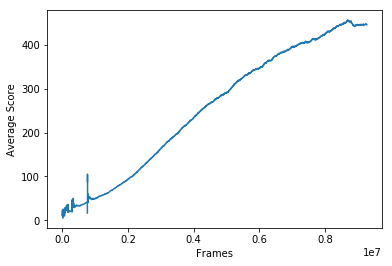

In [16]:
f = open('log_file.txt', 'r')
line = f.read().strip().split('\n')
values = []
for ln in line:
    segs = ln.split('/')
    values.append(float(segs[-1].split(' ')[-1]))
plt.figure()
plt.plot(np.arange(len(values))*1000, values)
plt.xlabel('Frames')
plt.ylabel('Average Score')
plt.show()

In [17]:
#net = torch.load('saving_nets/' + GAME + '-dqn' + str(2876000) + '.txt')
net = torch.load('bird-dqn8500000-Copy1.txt')
FINAL_EPSILON = 0.0000 # epsilon的最终值
BATCH = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出

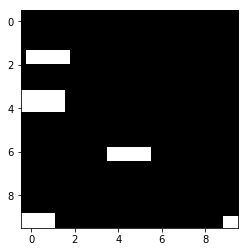

In [20]:
# 开始在内存／GPU上定义一个网络
use_cuda = torch.cuda.is_available() #检测本台机器中是否有GPU

# 如果有GPU，就把神经网络全部搬到GPU内存中做运算
net = net.cuda() if use_cuda else net

# 开启一个游戏进程，开始与游戏引擎通话
game_state = GameState()

# 状态打印log记录位置
#a_file = open("logs_" + GAME + "/readout.txt", 'w')
#h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# 将游戏设置为初始状态，并获得一个80*80的游戏湖面
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = cv2.cvtColor(cv2.resize(x_t, (80, 80)), cv2.COLOR_BGR2GRAY)
ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)

# 将初始的游戏画面叠加成4张作为神经网络的初始输入状态s_t
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)

# 设置初始的epsilon（采取随机行动的概率），并准备训练
epsilon = FINAL_EPSILON
t = 0# 记录每轮平均得分的容器
scores = []
all_turn_scores = []

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)

i = 0
while "flappy bird" != "angry bird":
    i += 1
    # 开始游戏循环
    ######################################################
    ##########首先，按照贪婪策略选择一个行动 ##################
    s = Variable(torch.from_numpy(s_t).type(torch.FloatTensor))
    s = s.cuda() if use_cuda else s
    s = s.view(-1, s.size()[0], s.size()[1], s.size()[2])
    # 获取当前时刻的游戏画面，输入到神经网络中
    readout, h_fc1 = net(s)
    # 神经网络产生的输出为readout：选择每一个行动的预期Q值
    readout = readout.cpu() if use_cuda else readout
    # readout为一个二维向量，分别对应每一个动作的预期Q值
    readout_t = readout.data.numpy()[0]

    # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
    # 1-epsilon的概率按照预期输出最大的Q值给出行动
    a_t = np.zeros([ACTIONS])
    action_index = 0
    if t % FRAME_PER_ACTION == 0:
        # 如果当前帧可以行动，则
        if random.random() <= epsilon:
            # 产生随机行动
            #print("----------Random Action----------")
            action_index = random.randrange(ACTIONS)
        else:
            # 选择神经网络判断的预期Q最大的行动
            action_index = np.argmax(readout_t)
        a_t[action_index] = 1
    else:
        a_t[0] = 1 # do nothing
    ######################################################################### 
    ##########其次，将选择好的行动输入给游戏引擎，并得到下一帧的状态 ################### 
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    # 返回的x_t1_colored为游戏画面，r_t为本轮的得分，terminal为游戏在本轮是否已经结束
    
    # 记录一下每一步的成绩
    scores.append(r_t)
    if terminal:
        # 当游戏结束的时候，计算一下本轮的总成绩，并将总成绩存储到all_turn_scores中
        all_turn_scores.append(sum(scores))
        scores = []
    
    # 对游戏的原始画面做相应的处理，从而变成一张80*80的，朴素的（无背景画面）的图
    x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
    x_t1 = np.reshape(x_t1, (1, 80, 80))
    # 将当前帧的画面和前三帧的画面合并起来作为Agent获得的环境反馈结果
    s_t1 = np.append(x_t1, s_t[:3, :, :], axis=0)
    s_t = s_t1
    t += 1
    clear_output(wait = True)
    
    image = np.transpose(x_t1_colored, (1, 0, 2))
    img.set_data(image)
    img.autoscale()
    display(fig)
    
    if i > 500:
        break